### Imports

In [1]:
import os
import time
import math
import random
import pickle
import shutil
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from forecasters import *
from autoencoder import *
from utils import *
from data import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

### Configuration Setup

Defines experiment parameters, including latent dimension size, datasets (length and window size),  and distance metrics. The compute device (CPU/GPU) is selected automatically.

The experiment will be conducted using three distinct datasets:
- Energy Dataset: 
- River Flow Dataset:
- Temperatures Dataset:
- Births Dataset:

In [2]:
# Directory paths for saving and loading components
AE_DIR = "trained_autoencoders"
FORECASTERS_DIR= "trained_forecasters"
RESULTS_DIR = "results"

# Configuration Parameters
latent_dim = 8

# Dataset configurations: (Name, Class, Sequence Length, Window Size)
ts_configs = [
    ("Energy",       PowerDemand,  3000, 10),
    ("RiverFlow",    Saugeen,      3000, 10),
    ("Temperatures", Temperatures, 3000, 10),
    ("Births",       Births,       3000, 10)
]

# Flags to toggle use of autoencoder embeddings
autoencoder_embedding_flags = [False, True]

# Distance metrics to evaluate
metrics_list = ["euclidean", "manhattan", "cosine", "dtw"]

# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Autoencoder Training and Evaluation

For each dataset, a convolutional autoencoder is trained on windowed time-series data using MSE loss. The model is trained for 30 epochs and saved for later use.


Training AE on Energy (window_size=10)
  Epoch 1/30 — loss: 0.943931
  Epoch 2/30 — loss: 0.386024
  Epoch 3/30 — loss: 0.256550
  Epoch 4/30 — loss: 0.214145
  Epoch 5/30 — loss: 0.182876
  Epoch 6/30 — loss: 0.167102
  Epoch 7/30 — loss: 0.153896
  Epoch 8/30 — loss: 0.140851
  Epoch 9/30 — loss: 0.134852
  Epoch 10/30 — loss: 0.128739
  Epoch 11/30 — loss: 0.118563
  Epoch 12/30 — loss: 0.115779
  Epoch 13/30 — loss: 0.113406
  Epoch 14/30 — loss: 0.105571
  Epoch 15/30 — loss: 0.101931
  Epoch 16/30 — loss: 0.098212
  Epoch 17/30 — loss: 0.096947
  Epoch 18/30 — loss: 0.094785
  Epoch 19/30 — loss: 0.093259
  Epoch 20/30 — loss: 0.091237
  Epoch 21/30 — loss: 0.088515
  Epoch 22/30 — loss: 0.084713
  Epoch 23/30 — loss: 0.084494
  Epoch 24/30 — loss: 0.080728
  Epoch 25/30 — loss: 0.081202
  Epoch 26/30 — loss: 0.079959
  Epoch 27/30 — loss: 0.080084
  Epoch 28/30 — loss: 0.078502
  Epoch 29/30 — loss: 0.074592
  Epoch 30/30 — loss: 0.074314
Saved AE: trained_autoencoders\ae_Energ

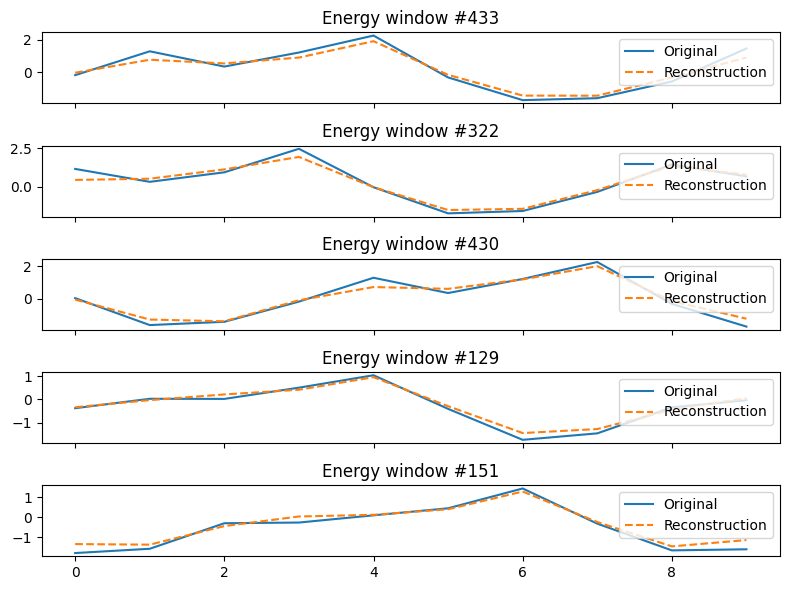


Training AE on RiverFlow (window_size=10)
  Epoch 1/30 — loss: 0.485080
  Epoch 2/30 — loss: 0.225491
  Epoch 3/30 — loss: 0.215662
  Epoch 4/30 — loss: 0.178578
  Epoch 5/30 — loss: 0.146284
  Epoch 6/30 — loss: 0.118665
  Epoch 7/30 — loss: 0.120651
  Epoch 8/30 — loss: 0.133866
  Epoch 9/30 — loss: 0.107373
  Epoch 10/30 — loss: 0.127399
  Epoch 11/30 — loss: 0.124760
  Epoch 12/30 — loss: 0.133142
  Epoch 13/30 — loss: 0.111414
  Epoch 14/30 — loss: 0.138463
  Epoch 15/30 — loss: 0.152969
  Epoch 16/30 — loss: 0.132380
  Epoch 17/30 — loss: 0.114159
  Epoch 18/30 — loss: 0.109167
  Epoch 19/30 — loss: 0.092125
  Epoch 20/30 — loss: 0.105451
  Epoch 21/30 — loss: 0.115592
  Epoch 22/30 — loss: 0.079602
  Epoch 23/30 — loss: 0.082499
  Epoch 24/30 — loss: 0.079915
  Epoch 25/30 — loss: 0.082056
  Epoch 26/30 — loss: 0.090127
  Epoch 27/30 — loss: 0.088828
  Epoch 28/30 — loss: 0.070729
  Epoch 29/30 — loss: 0.099193
  Epoch 30/30 — loss: 0.087973
Saved AE: trained_autoencoders\ae_Ri


Training AE on Temperatures (window_size=10)
  Epoch 1/30 — loss: 0.843691
  Epoch 2/30 — loss: 0.516855
  Epoch 3/30 — loss: 0.341181
  Epoch 4/30 — loss: 0.263250
  Epoch 5/30 — loss: 0.220253
  Epoch 6/30 — loss: 0.201445
  Epoch 7/30 — loss: 0.184021
  Epoch 8/30 — loss: 0.171475
  Epoch 9/30 — loss: 0.160916
  Epoch 10/30 — loss: 0.150508
  Epoch 11/30 — loss: 0.144200
  Epoch 12/30 — loss: 0.138721
  Epoch 13/30 — loss: 0.128272
  Epoch 14/30 — loss: 0.126164
  Epoch 15/30 — loss: 0.120129
  Epoch 16/30 — loss: 0.115027
  Epoch 17/30 — loss: 0.110267
  Epoch 18/30 — loss: 0.113804
  Epoch 19/30 — loss: 0.104344
  Epoch 20/30 — loss: 0.104490
  Epoch 21/30 — loss: 0.104959
  Epoch 22/30 — loss: 0.094125
  Epoch 23/30 — loss: 0.099029
  Epoch 24/30 — loss: 0.090031
  Epoch 25/30 — loss: 0.094526
  Epoch 26/30 — loss: 0.092295
  Epoch 27/30 — loss: 0.088743
  Epoch 28/30 — loss: 0.092699
  Epoch 29/30 — loss: 0.091184
  Epoch 30/30 — loss: 0.083608
Saved AE: trained_autoencoders\ae


Training AE on Births (window_size=10)
  Epoch 1/30 — loss: 0.840835
  Epoch 2/30 — loss: 0.406182
  Epoch 3/30 — loss: 0.278601
  Epoch 4/30 — loss: 0.233360
  Epoch 5/30 — loss: 0.199798
  Epoch 6/30 — loss: 0.179717
  Epoch 7/30 — loss: 0.169845
  Epoch 8/30 — loss: 0.156968
  Epoch 9/30 — loss: 0.143923
  Epoch 10/30 — loss: 0.138525
  Epoch 11/30 — loss: 0.132576
  Epoch 12/30 — loss: 0.129030
  Epoch 13/30 — loss: 0.119040
  Epoch 14/30 — loss: 0.119317
  Epoch 15/30 — loss: 0.113536
  Epoch 16/30 — loss: 0.107196
  Epoch 17/30 — loss: 0.104917
  Epoch 18/30 — loss: 0.104787
  Epoch 19/30 — loss: 0.102362
  Epoch 20/30 — loss: 0.100266
  Epoch 21/30 — loss: 0.093552
  Epoch 22/30 — loss: 0.092771
  Epoch 23/30 — loss: 0.091258
  Epoch 24/30 — loss: 0.089289
  Epoch 25/30 — loss: 0.089377
  Epoch 26/30 — loss: 0.087179
  Epoch 27/30 — loss: 0.084739
  Epoch 28/30 — loss: 0.082989
  Epoch 29/30 — loss: 0.082476
  Epoch 30/30 — loss: 0.080775
Saved AE: trained_autoencoders\ae_Birth

In [3]:
# Autoencoder Training Settings
epochs    = 30
lr        = 1e-3
dropout_p = 0.3

# Ensure a clean autoencoders/ directory
if os.path.exists(AE_DIR):
    shutil.rmtree(AE_DIR)
os.makedirs(AE_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=128, shuffle=True
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_val)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

### Forecaster Training

For each dataset, a collection of classical and neural network-based forecasters are trained on the training split. Each trained model is saved as a serialized `.pkl` file for future evaluation and selection.

In [4]:
# Ensure a clean forecasters/ directory
if os.path.exists(FORECASTERS_DIR):
    shutil.rmtree(FORECASTERS_DIR)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(),
    "DT": DecisionTreeForecaster(),
    "MLP1": MLPForecaster(hidden_layer_sizes=(64,)),
    "MLP2": MLPForecaster(hidden_layer_sizes=(64, 32)),
    "MLP3": MLPForecaster(hidden_layer_sizes=(128, 64, 32)),
    "LSTM1": LSTMForecaster(),
    "LSTM2": LSTMForecaster(num_layers= 2),
    "LSTM3": LSTMForecaster(num_layers= 3),
    "BiLSTM1": BiLSTMForecaster(),
    "BiLSTM2": BiLSTMForecaster(num_layers= 2),
    "BiLSTM3": BiLSTMForecaster(num_layers= 3),
    "CNNLSTM1": CNNLSTMForecaster(),
    "CNNLSTM2": CNNLSTMForecaster(lstm_num_layers= 2),
    "CNNLSTM3": CNNLSTMForecaster(lstm_num_layers= 3),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train)

        # save the entire model object as a .pkl
        save_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE")


→ Dataset: Energy (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training RandomForest… DONE
    → Training SVR… DONE
    → Training GradientBoosting… DONE
    → Training DT… DONE
    → Training MLP1… DONE
    → Training MLP2… DONE
    → Training MLP3… DONE
    → Training LSTM1… 1/30 0.97573 | 15/30 0.13443 | 30/30 0.07550 | DONE
    → Training LSTM2… 1/30 0.98642 | 15/30 0.12318 | 30/30 0.07873 | DONE
    → Training LSTM3… 1/30 0.99129 | 15/30 0.13463 | 30/30 0.08905 | DONE
    → Training BiLSTM1… 1/30 0.95632 | 15/30 0.13862 | 30/30 0.07857 | DONE
    → Training BiLSTM2… 1/30 0.96331 | 15/30 0.07392 | 30/30 0.05777 | DONE
    → Training BiLSTM3… 1/30 0.98115 | 15/30 0.08249 | 30/30 0.06310 | DONE
    → Training CNNLSTM1… 1/30 0.93191 | 15/30 0.08096 | 30/30 0.05822 | DONE
    → Training CNNLSTM2… 1/30 0.96099 | 15/30 0.08683 | 30/30 0.06630 | DONE
    → Training CNNLSTM3… 1/30 0.98531 | 15/30 0.10911 | 30/30 

### Model Loading

Pretrained autoencoders and forecasters are loaded from disk for each dataset. These models are stored in a dictionary for subsequent evaluation and model selection steps.

In [5]:
os.makedirs(AE_DIR, exist_ok=True)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

loaded = {}
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {AE_DIR}{os.sep}")
    
    # Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA",
        "ExpSmoothing",
        "LinearRegression",
        "RandomForest",
        "SVR",
        "GradientBoosting",
        "DT",
        "MLP1",
        "MLP2",
        "MLP3",
        "LSTM1",
        "LSTM2",
        "LSTM3",
        "BiLSTM1",
        "BiLSTM2",
        "BiLSTM3",
        "CNNLSTM1",
        "CNNLSTM2",
        "CNNLSTM3",
    ]:
        pkl_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
    print(f"     Forecasters loaded from {FORECASTERS_DIR}{os.sep}")
    
    # Store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Energy (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for RiverFlow (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for Temperatures (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for Births (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\


### Validation Phase: Region of Competence Construction

Each validation window is used to evaluate all forecasters. The model with the lowest prediction error receives the window as part of its Region of Competence (RoC), stored in both raw and latent representations.


In [6]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")


=== Validation RoC for Energy (window_size=10) ===
RoC sizes
  ARIMA                22 entries
  ExpSmoothing         27 entries
  LinearRegression     38 entries
  RandomForest         32 entries
  SVR                  80 entries
  GradientBoosting     45 entries
  DT                   50 entries
  MLP1                 34 entries
  MLP2                 67 entries
  MLP3                 41 entries
  LSTM1                33 entries
  LSTM2                33 entries
  LSTM3                21 entries
  BiLSTM1              55 entries
  BiLSTM2              38 entries
  BiLSTM3              35 entries
  CNNLSTM1             36 entries
  CNNLSTM2             28 entries
  CNNLSTM3             25 entries

=== Validation RoC for RiverFlow (window_size=10) ===
RoC sizes
  ARIMA                26 entries
  ExpSmoothing         68 entries
  LinearRegression     44 entries
  RandomForest         37 entries
  SVR                  24 entries
  GradientBoosting     32 entries
  DT                   

### Latent Space Clustering

K-means clustering is applied to each model’s latent Region of Competence (RoC). The optimal number of clusters is estimated, and cluster centers are decoded for visualization. These centers will be used for Cluster-Based model selection.

> Clustering method: All latent windows are flattened and stacked into a 2D array to serve as input to K-Means algorithm. Then for each value $k$ $\in$ [2, $k_{max}$] we fit a K-Means model, recording the associated inertia (within-cluster sum of squares). The "elbow point" in the inertia curve is identified using the KneeLocator algorithm, selecting the number of clusters that yields the best balance between model complexity and fit quality. The final K-Means clustering is performed with the selected number of clusters, and the resulting cluster centers are reshaped to match the original latent window shape and stored as tensors.

Bottleneck size: 8

=== Compute K-means centers for Energy (window_size=10) ===



=== Compute K-means centers for RiverFlow (window_size=10) ===


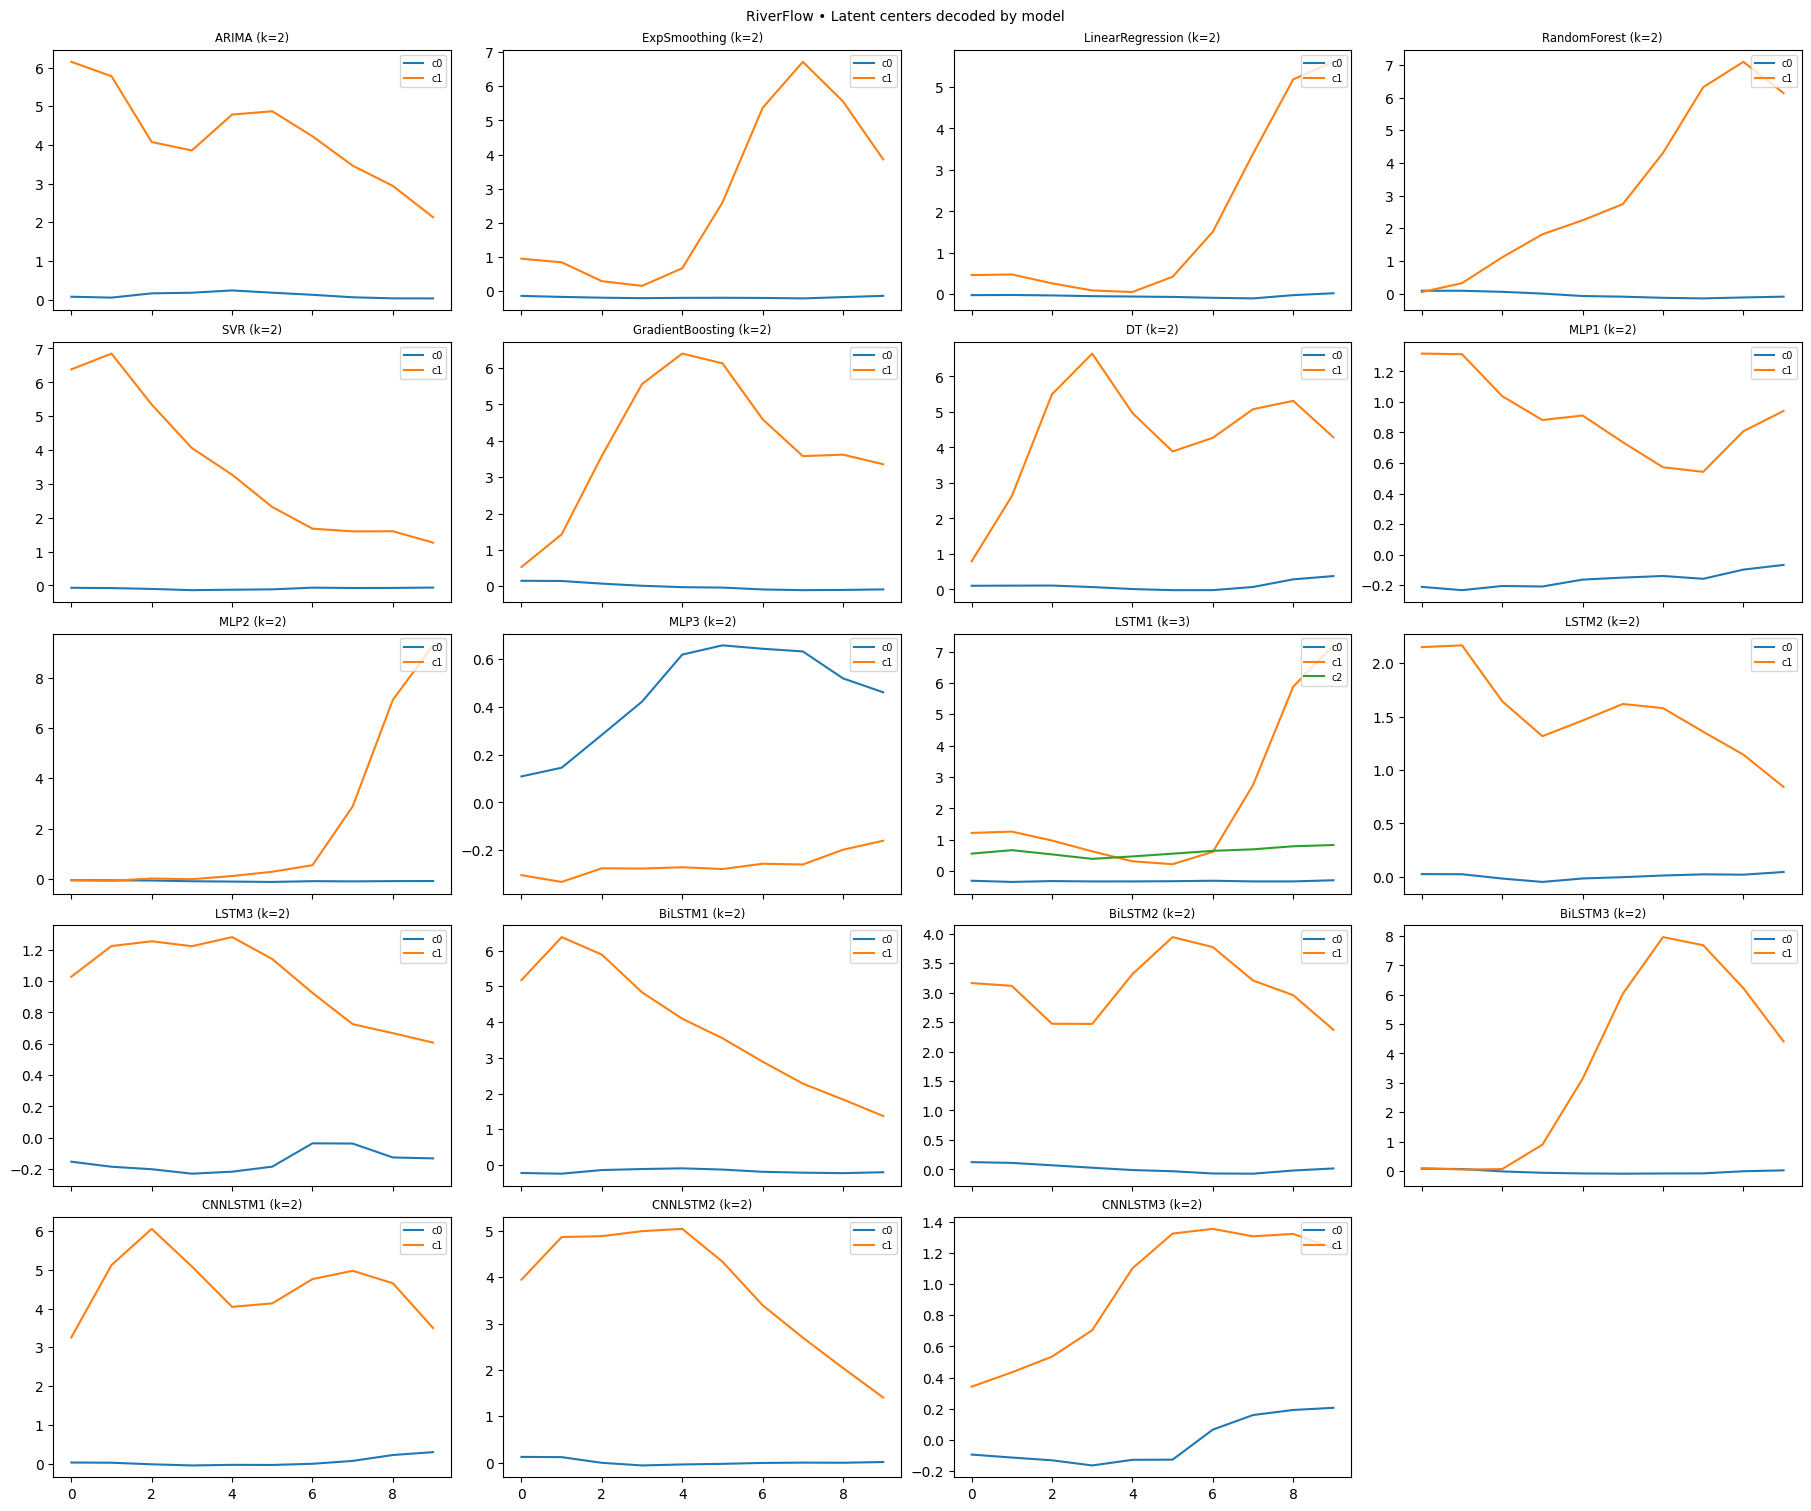


=== Compute K-means centers for Temperatures (window_size=10) ===


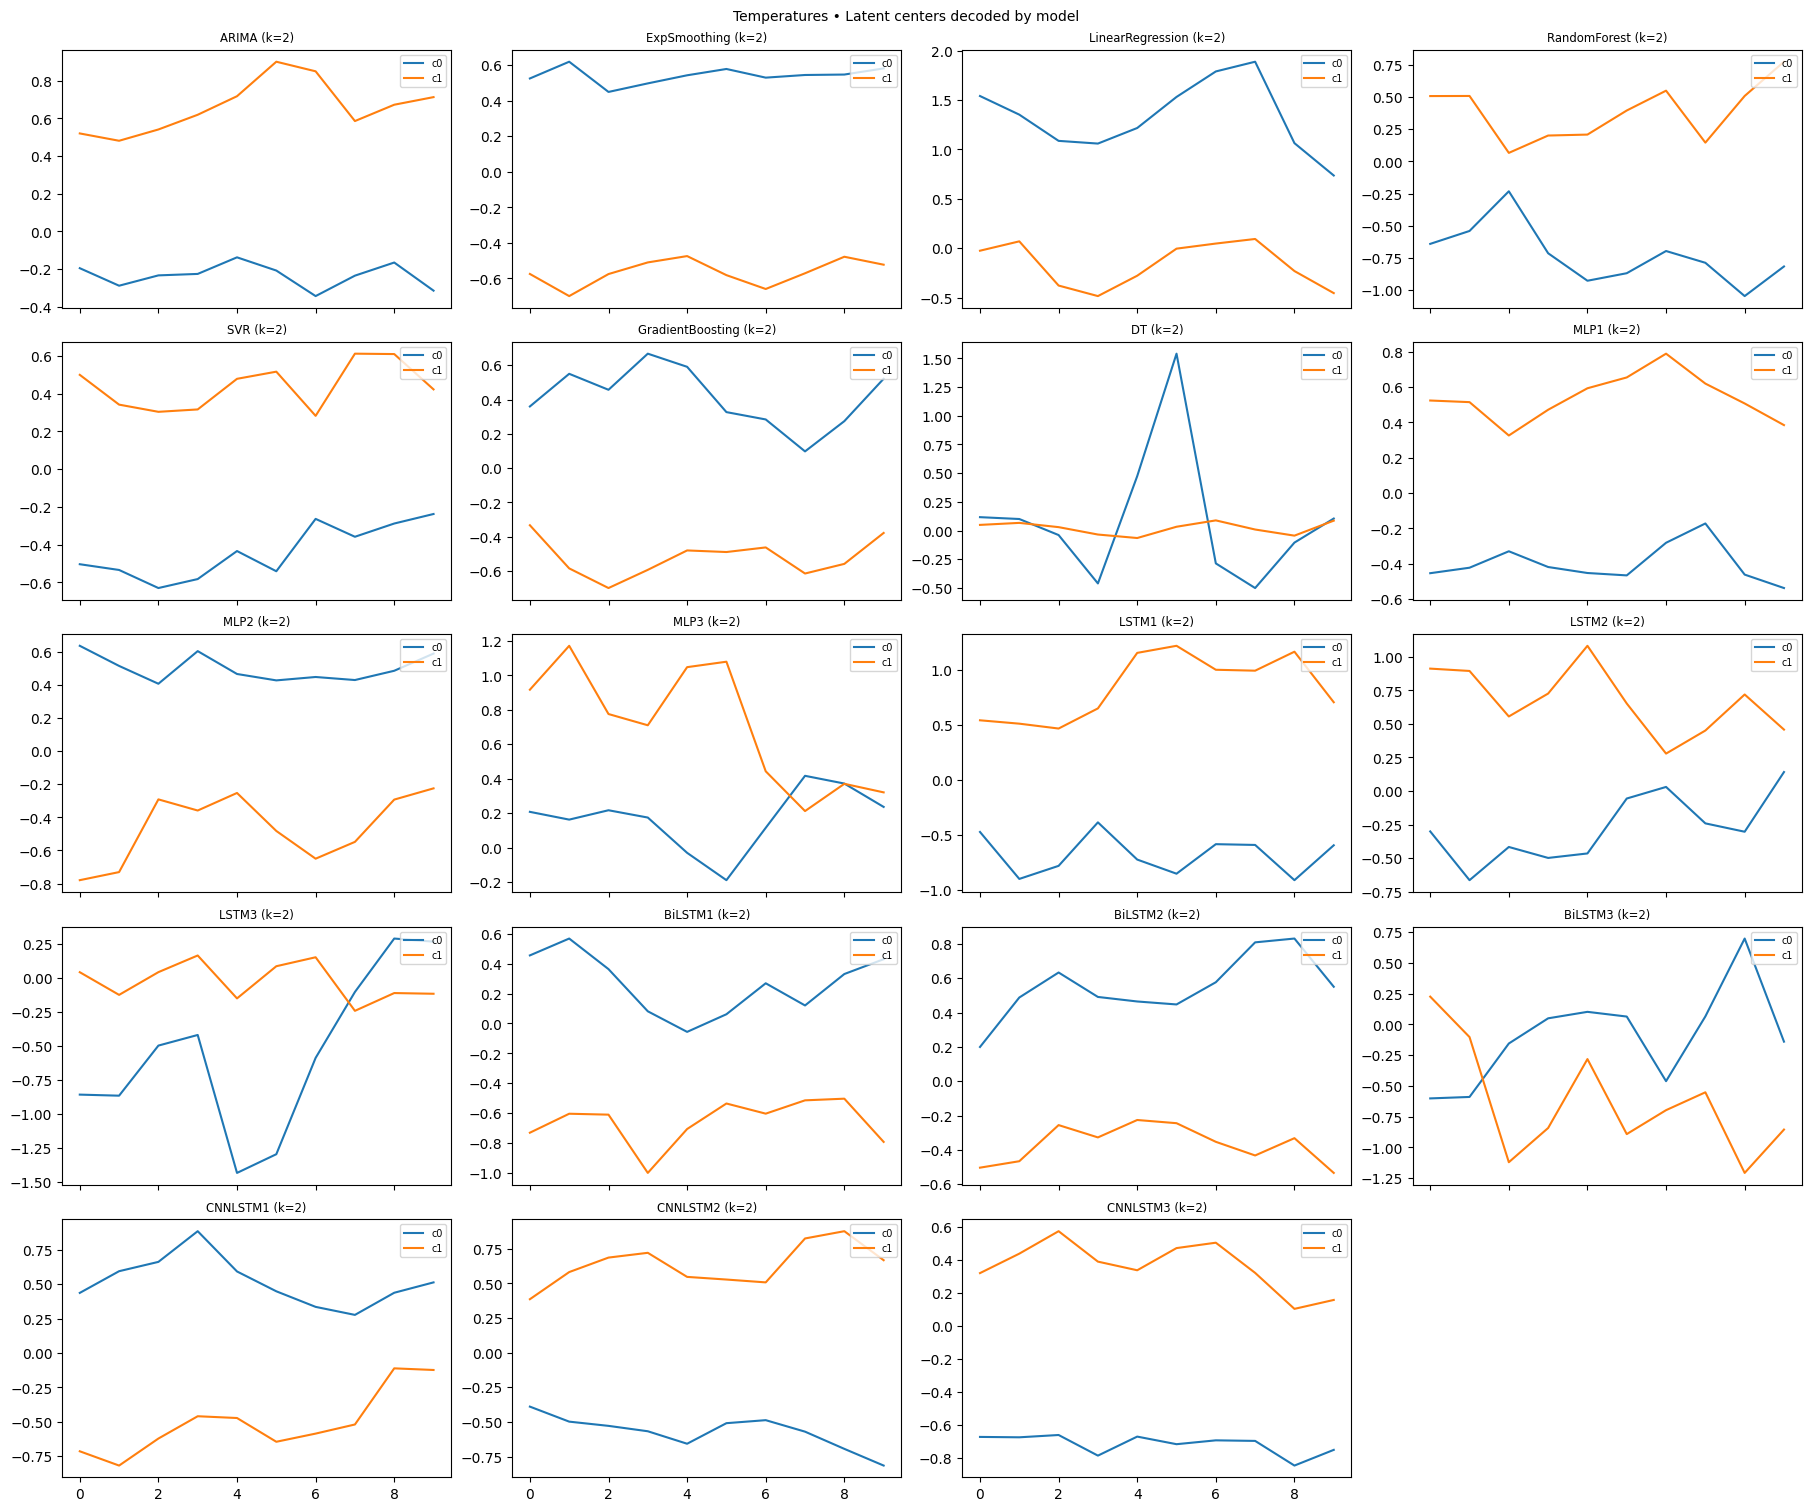


=== Compute K-means centers for Births (window_size=10) ===


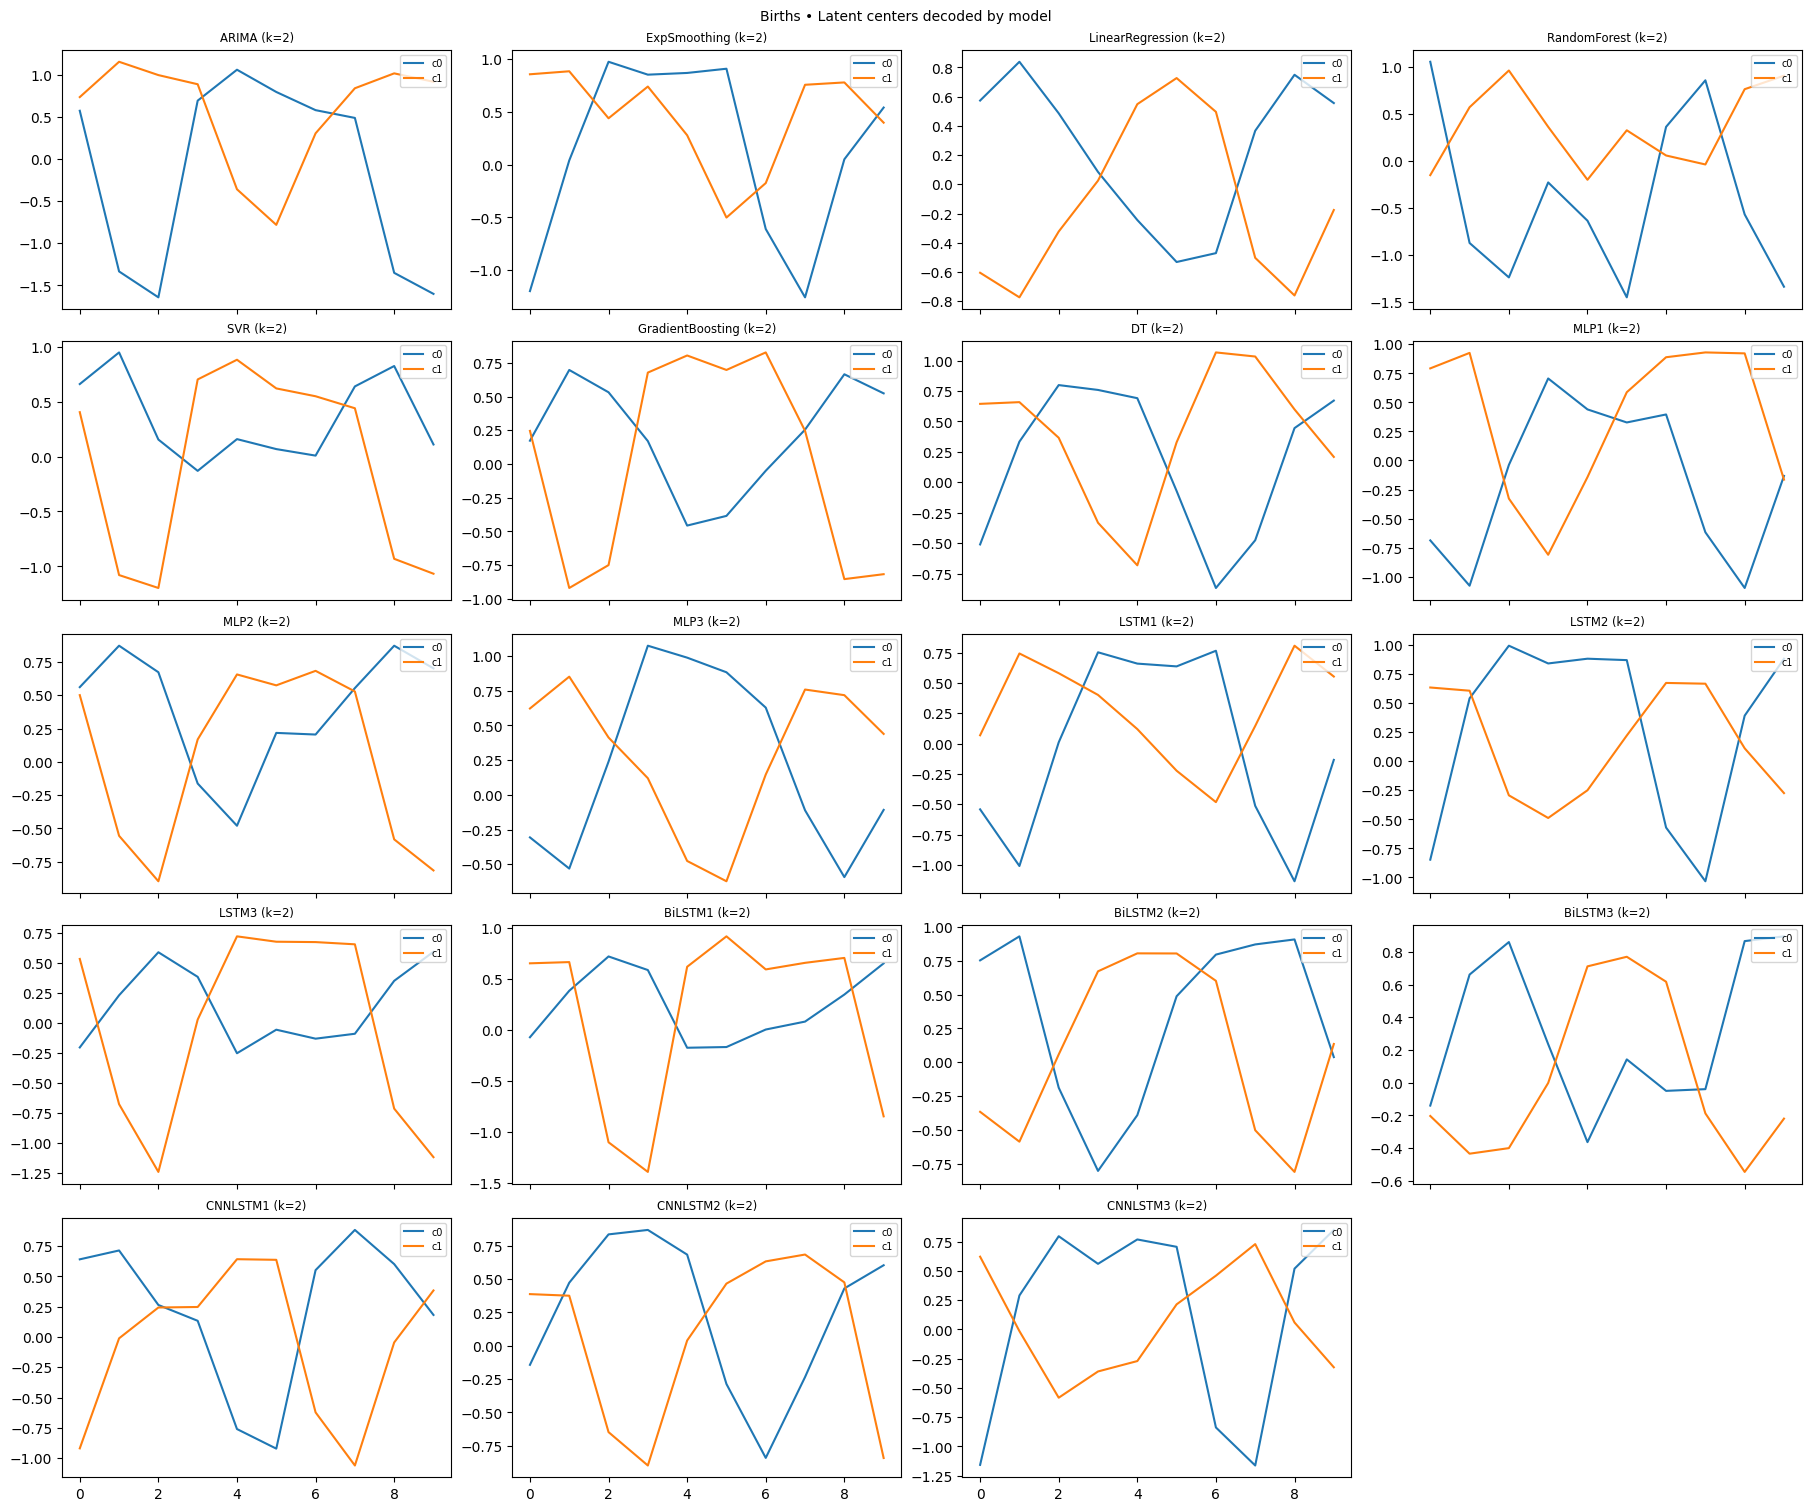

In [21]:
n_cols = 4
print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Compute K-means centers for {ds_name} (window_size={window_size}) ===")

    # Load models
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear previous centers
    for model in forecasters.values():
        model.centers = {"raw": [], "latent": []}

    # Determine device for decoding latent centers
    decoder_device = next(ae.decoder.parameters()).device

    for name, model in forecasters.items():
        # Cluster latent RoCs
        N_latent = len(model.rocs["latent"])
        if N_latent > 0:
            k_max_latent = np.sqrt(N_latent / 2)
            model.compute_kmeans_centers(mode="latent", k_max=k_max_latent)

        # Cluster raw RoCs
        N_raw = len(model.rocs["raw"])
        if N_raw > 0:
            k_max_raw = np.sqrt(N_raw / 2)
            model.compute_kmeans_centers(mode="raw", k_max=k_max_raw)

    # Plot all latent cluster centers (decoded)
    names = [n for n in forecasters if len(forecasters[n].centers["latent"]) > 0]
    n_models = len(names)
    if n_models == 0:
        print(" No models have centers to plot.")
        continue

    n_rows = math.ceil(n_models / n_cols)

    fig_width = n_cols * 4.5
    fig_height = n_rows * 3

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, fig_height),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, name in zip(axes, names):
        model = forecasters[name]
        for idx, c in enumerate(model.centers["latent"]):
            # ensure tensor on correct device
            c_tensor = c if isinstance(c, torch.Tensor) else torch.tensor(
                c, dtype=torch.float32
            )
            c_batch = c_tensor.unsqueeze(0).to(decoder_device)  # shape (1, C, L)
            decoded = ae.decoder(c_batch)                       # -> (1, 1, window_size)
            ts_data = decoded.detach().cpu().numpy().flatten()
            ax.plot(ts_data, label=f"c{idx}")
        ax.set_title(f"{name} (k={len(model.centers['latent'])})", fontsize="small")
        ax.legend(loc="upper right", fontsize="x-small")

    # turn off any unused subplots
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent centers decoded by model", fontsize="medium")
    plt.show()



=== Plot latent cluster samples for Energy (compact grid) ===


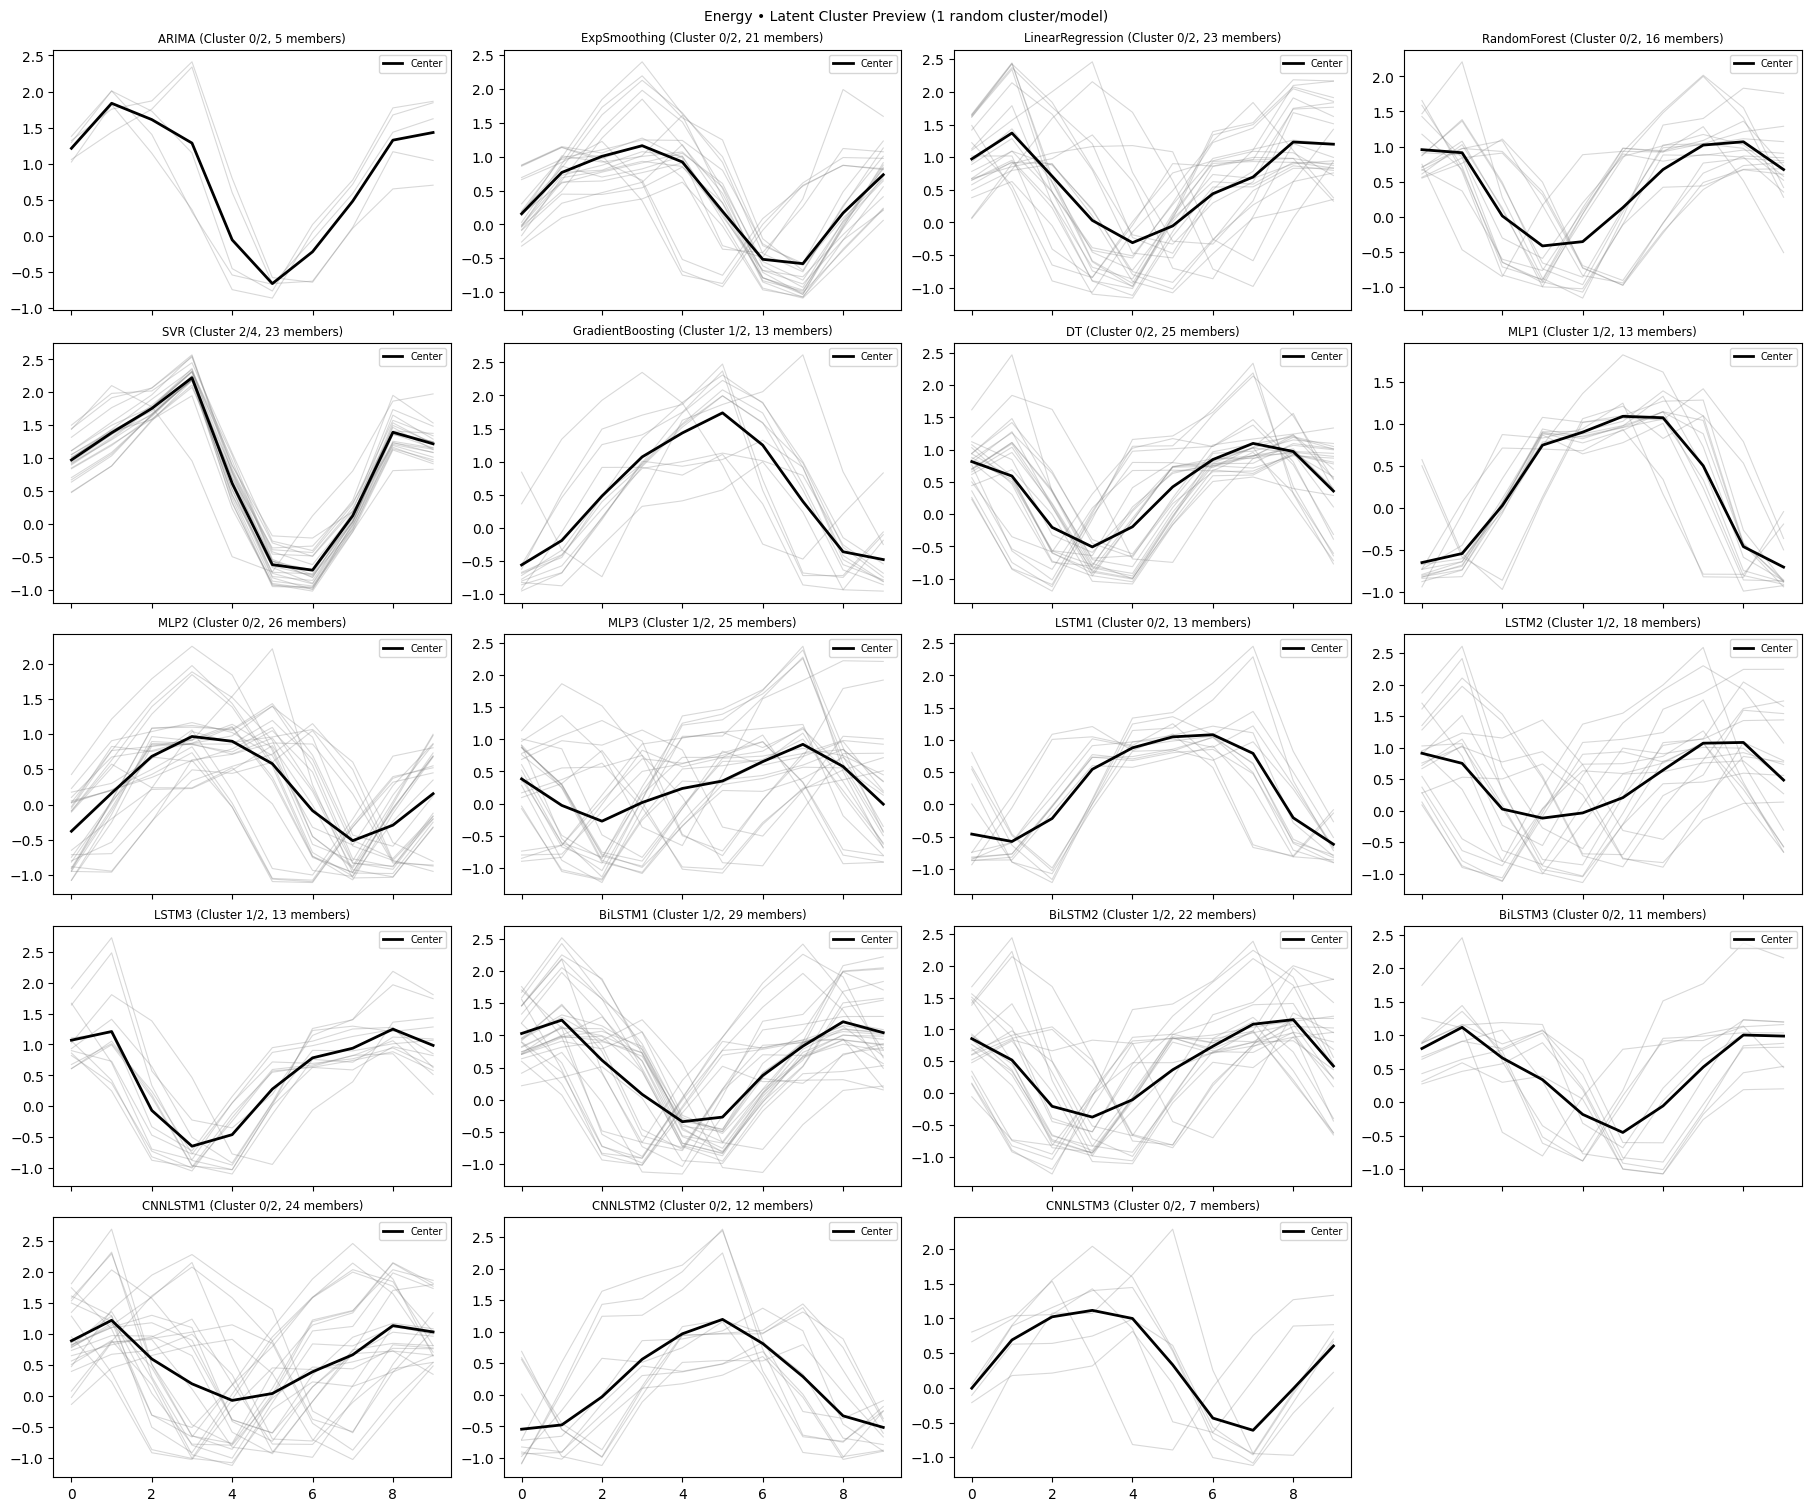


=== Plot latent cluster samples for RiverFlow (compact grid) ===


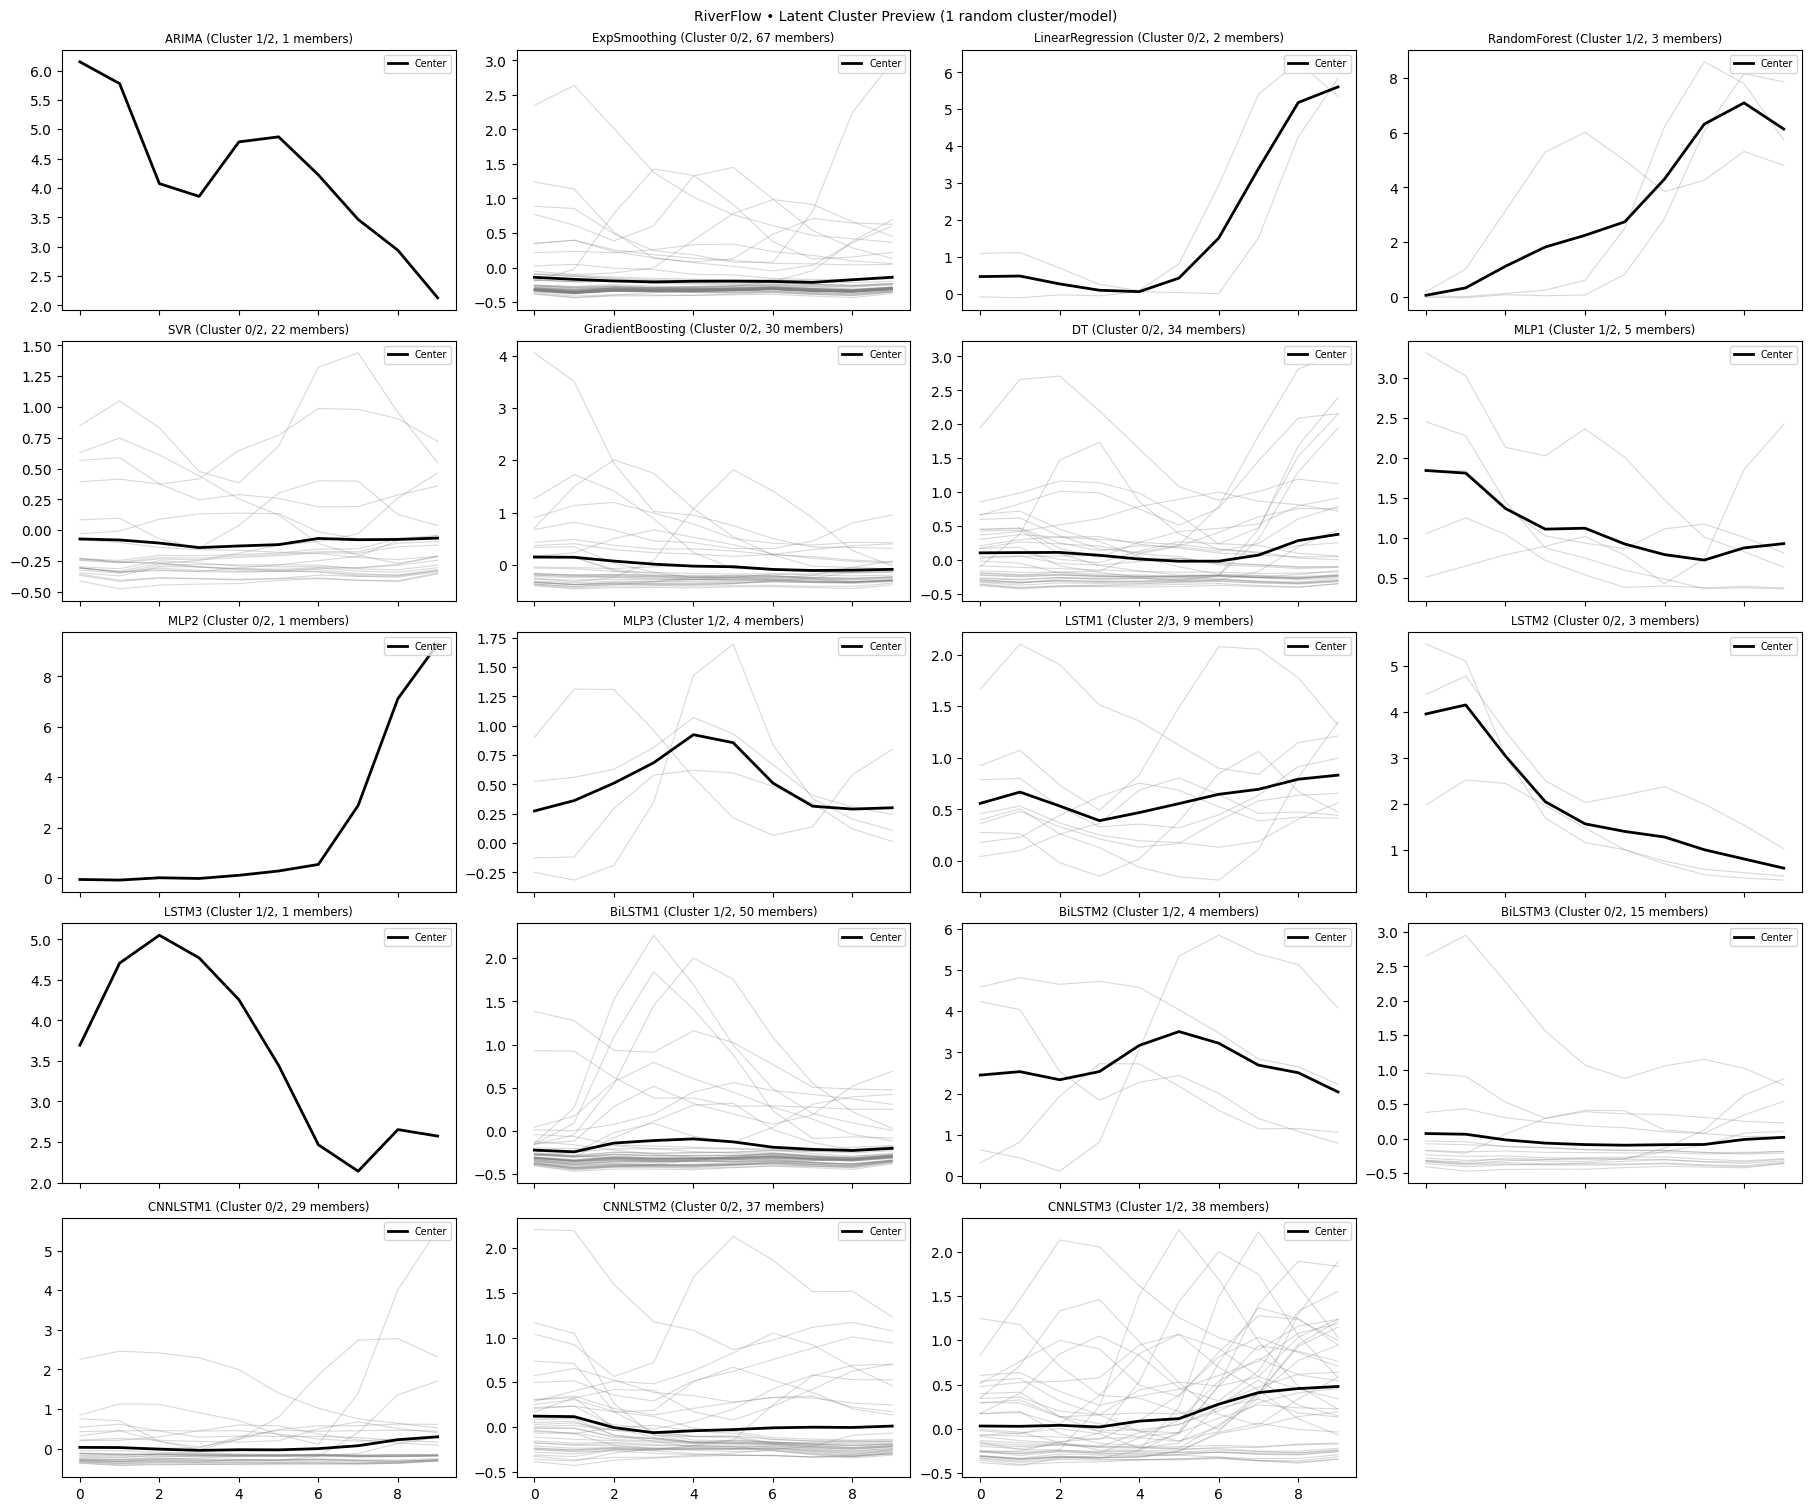


=== Plot latent cluster samples for Temperatures (compact grid) ===


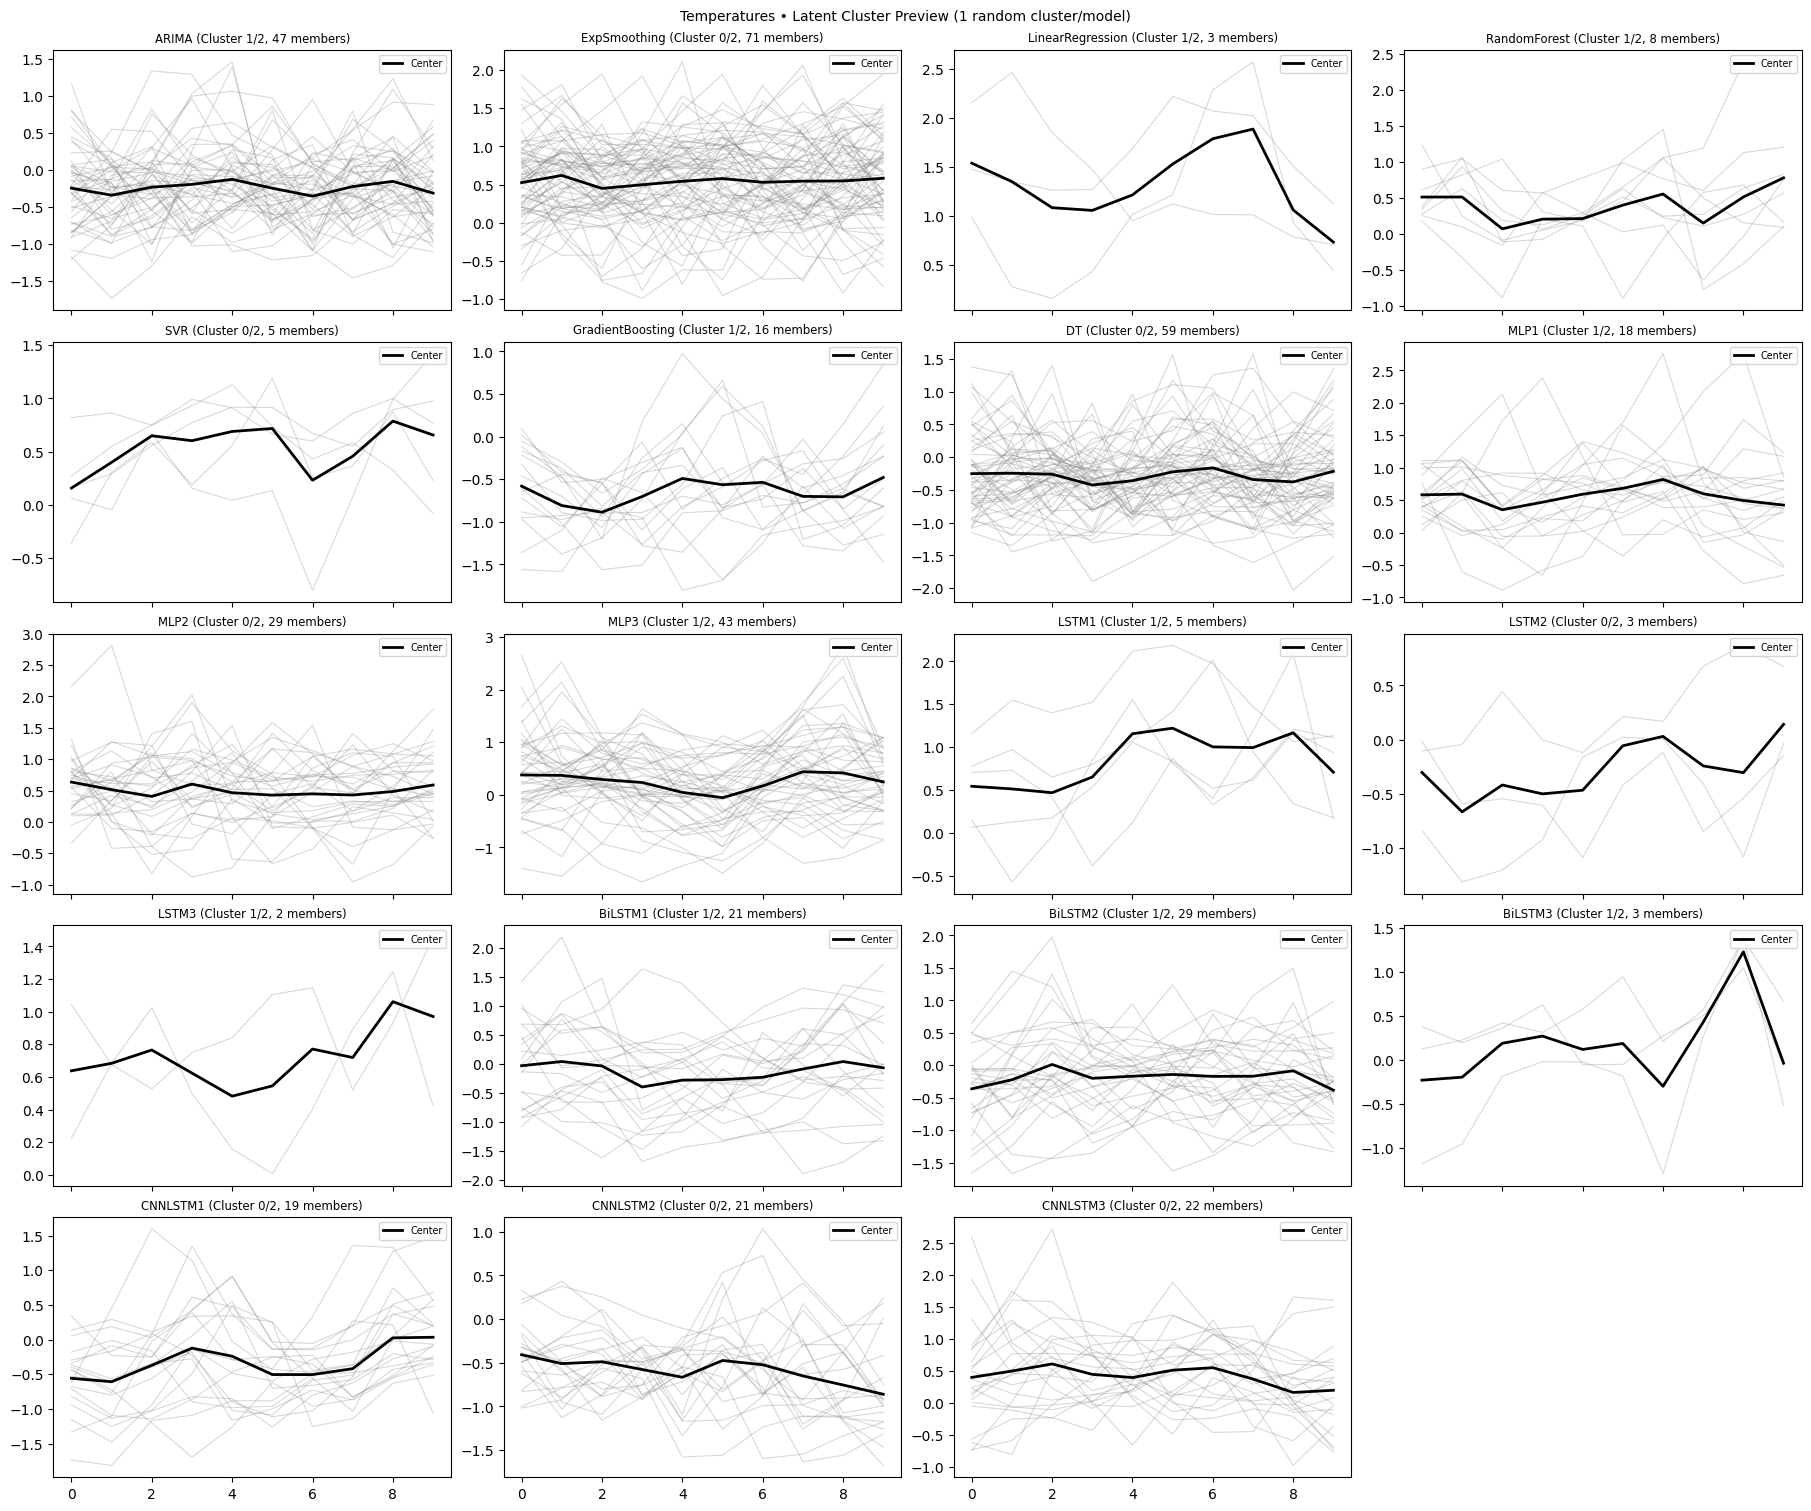


=== Plot latent cluster samples for Births (compact grid) ===


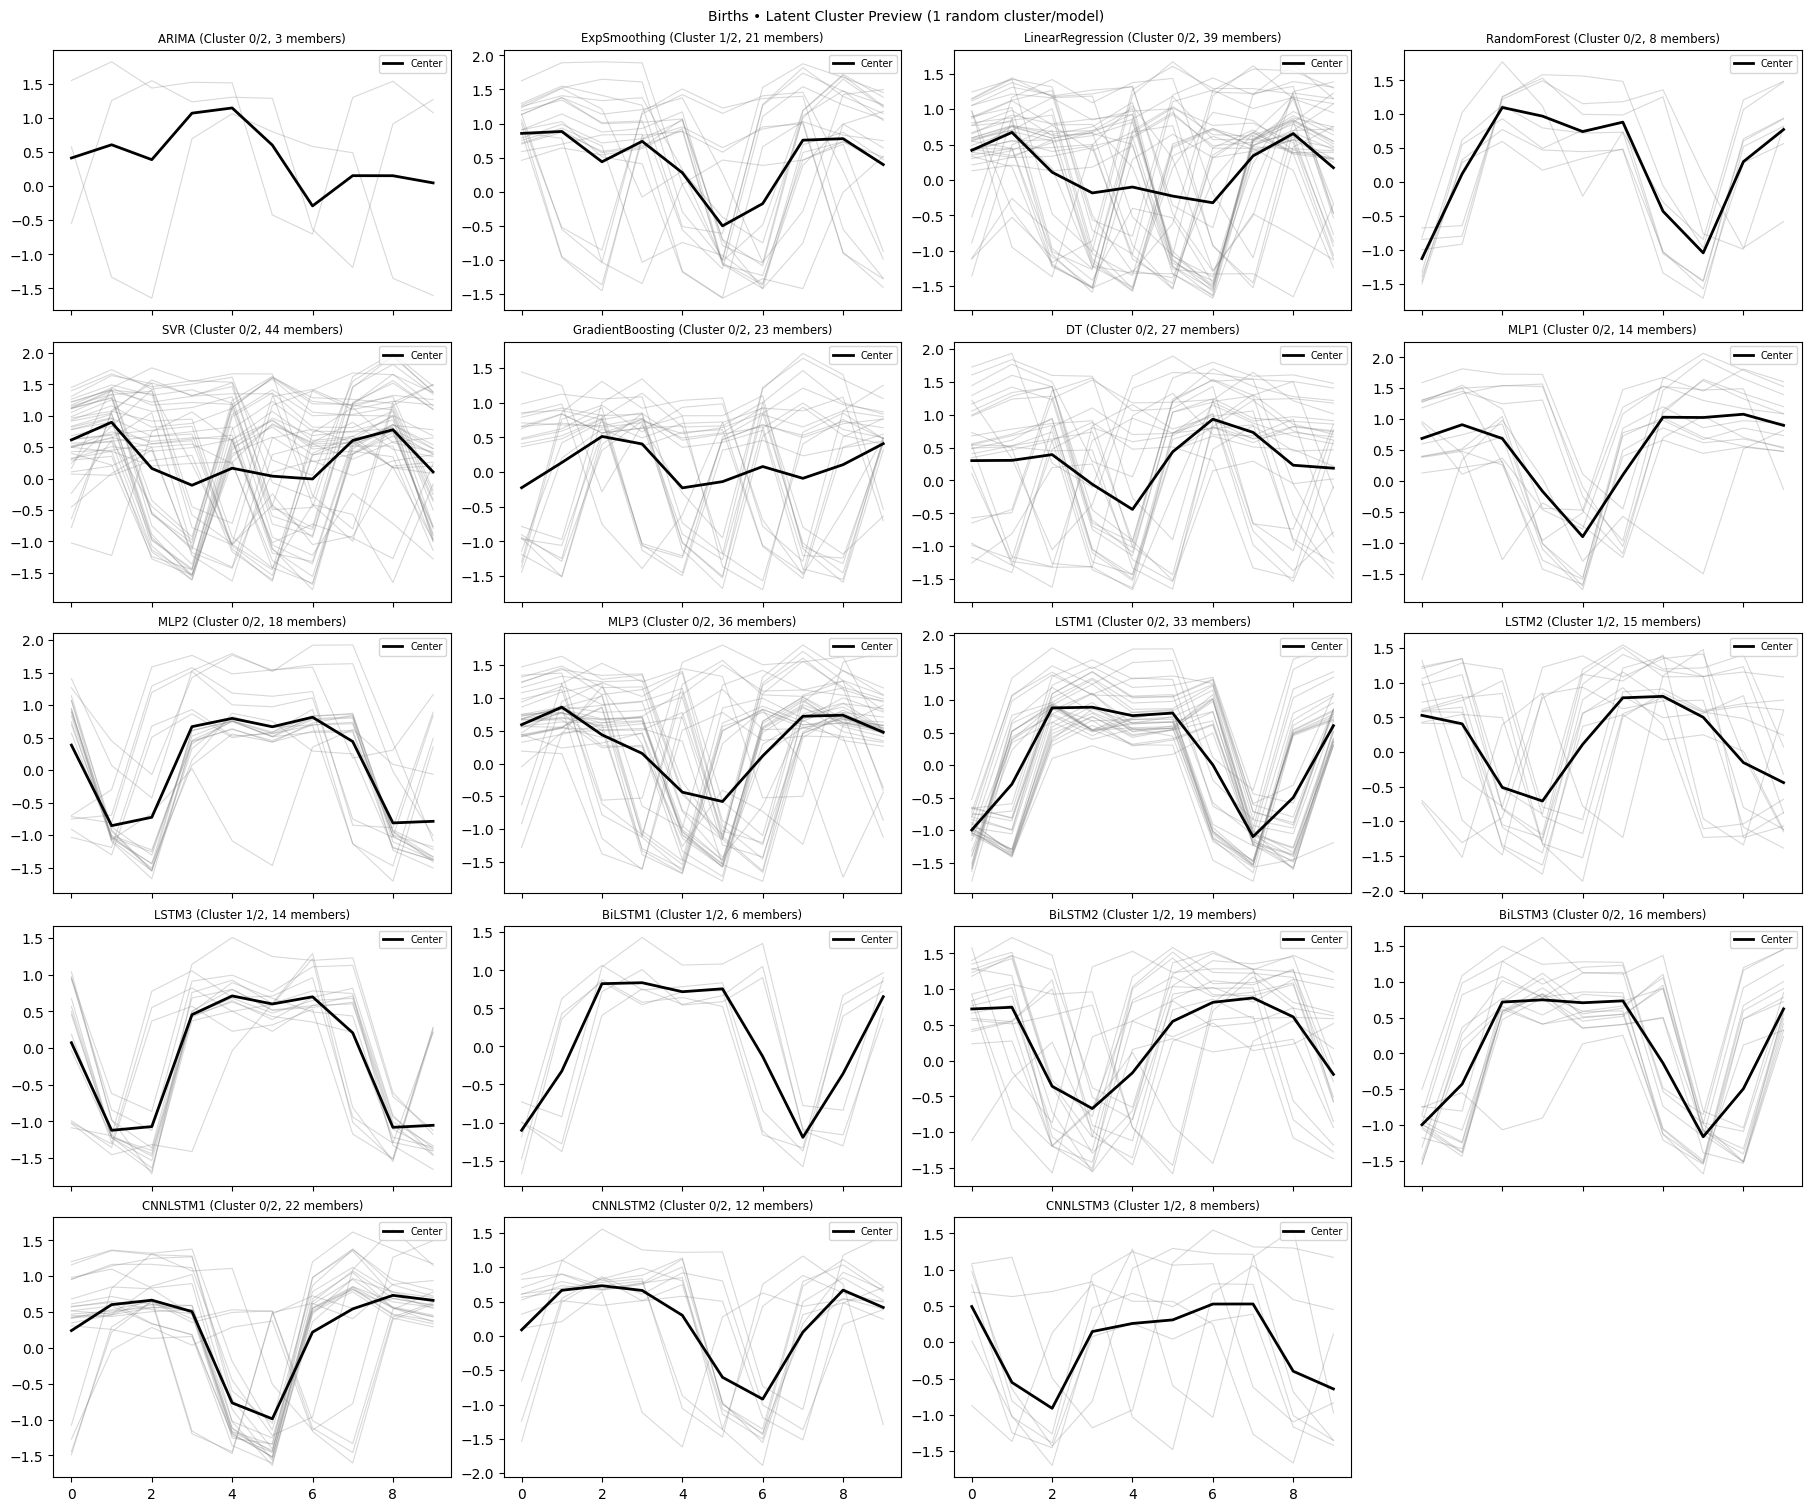

In [20]:
n_cols = 4 # You can adjust this

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Plot latent cluster samples for {ds_name} (compact grid) ===")

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    decoder_device = next(ae.decoder.parameters()).device

    valid_models = []
    for name, model in forecasters.items():
        centers = model.centers["latent"]
        windows = model.rocs["latent"]

        if len(centers) == 0 or len(windows) == 0:
            continue

        # Flatten latent windows
        X = np.vstack([
            (w.detach().cpu().numpy() if isinstance(w, torch.Tensor) else np.array(w)).flatten()
            for w in windows
        ])

        # Flatten latent centers
        C = np.vstack([
            (c.detach().cpu().numpy() if isinstance(c, torch.Tensor) else np.array(c)).flatten()
            for c in centers
        ])

        # Use KMeans.predict with existing centers
        km = KMeans(n_clusters=len(C), init=C, n_init=1, max_iter=1)
        labels = km.fit_predict(X)

        # Group windows by cluster
        cluster_to_indices = {i: [] for i in range(len(C))}
        for idx, label in enumerate(labels):
            cluster_to_indices[label].append(idx)

        valid_models.append((name, model, centers, cluster_to_indices, windows))

    n_models = len(valid_models)
    if n_models == 0:
        print(" No valid models to plot.")
        continue

    n_rows = math.ceil(n_models / n_cols)

    fig_width = n_cols * 4.5
    fig_height = n_rows * 3

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, fig_height),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, (name, model, centers, cluster_to_indices, windows) in zip(axes, valid_models):
        non_empty_clusters = [i for i, idxs in cluster_to_indices.items() if len(idxs) > 0]
        if not non_empty_clusters:
            ax.set_title(f"{name} (no populated clusters)", fontsize="small")
            ax.axis("off")
            continue

        chosen_c = random.choice(non_empty_clusters)
        member_indices = cluster_to_indices[chosen_c]

        for i in member_indices:
            w_tensor = windows[i].unsqueeze(0).to(decoder_device)
            decoded = ae.decoder(w_tensor).detach().cpu().numpy().flatten()
            ax.plot(decoded, alpha=0.3, linewidth=0.8, color='gray')

        c_tensor = centers[chosen_c].unsqueeze(0).to(decoder_device)
        decoded_center = ae.decoder(c_tensor).detach().cpu().numpy().flatten()
        ax.plot(decoded_center, color='black', linewidth=2, label="Center")

        ax.set_title(
            f"{name} (Cluster {chosen_c}/{len(centers)}, {len(member_indices)} members)",
            fontsize="small"
        )
        ax.legend(loc="upper right", fontsize="x-small")

    # Turn off unused axes
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent Cluster Preview (1 random cluster/model)",
                 fontsize="medium")
    plt.show()

## RQ1: Latent vs. Raw Space for Model Selection Across Distance Metrics

The goal is to compare the effectiveness of model selection based on similarity in latent space via autoencoder embeddings versus raw time-domain. This comparison is conducted across multiple distance measures, including Euclidean, Cosine, and Manhattan, applied in both raw and latent spaces.

### Test 1.1: Forecasting MSE Comparison

We compare one-step-ahead forecasting error (MSE) when selecting forecaster in raw vs. latent space using three distance metrics. For each, lower MSE from latent-space selection indicates that the latent embedding preserves meaningful similarity under the corresponding metric. 

In [9]:
# Lists to collect detailed disagreements, high-level summaries, and neighbor sets
disagreements = []
summary_list = []
neighbor_data = []

# Ensure a clean results/ directory
if os.path.exists(RESULTS_DIR):
    shutil.rmtree(RESULTS_DIR)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Bottleneck size: {latent_dim}")

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load forecasters
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows = len(X_test)

    for metric in metrics_list:
        # prepare neighbor-set collectors
        raw_neighbor_sets = []
        lat_neighbor_sets = []

        # ---- RAW inference ----
        t0 = time.perf_counter()
        raw_preds, raw_models = [], []
        for w in X_test:
            q = w
            best_name, best_dist = None, float("inf")
            window_dists = []
            for name, model in forecasters.items():
                for entry in model.rocs["raw"]:
                    d = compute_distance(q, entry, metric=metric)
                    window_dists.append((d, name))
                    if d < best_dist:
                        best_dist, best_name = d, name
            raw_models.append(best_name)
            window_dists.sort(key=lambda x: x[0])
            raw_neighbor_sets.append([name for _, name in window_dists[:5]])
            raw_preds.append(forecasters[best_name].predict(w))
        time_raw = time.perf_counter() - t0
        mse_raw  = mean_squared_error(y_test, raw_preds)

        # ---- LATENT inference ----
        t1 = time.perf_counter()
        lat_preds, lat_models = [], []
        for w in X_test:
            with torch.no_grad():
                q = ae.encode(w).cpu()
            best_name, best_dist = None, float("inf")
            window_dists = []
            for name, model in forecasters.items():
                for entry in model.rocs["latent"]:
                    d = compute_distance(q, entry, metric=metric)
                    window_dists.append((d, name))
                    if d < best_dist:
                        best_dist, best_name = d, name
            lat_models.append(best_name)
            window_dists.sort(key=lambda x: x[0])
            lat_neighbor_sets.append([name for _, name in window_dists[:5]])
            lat_preds.append(forecasters[best_name].predict(w))
        time_lat = time.perf_counter() - t1
        mse_lat  = mean_squared_error(y_test, lat_preds)

        # ---- Record neighbor‐sets for later Jaccard analysis ----
        for idx in range(n_windows):
            neighbor_data.append({
                "dataset":       ds_name,
                "metric":        metric,
                "win_idx":       idx,
                "raw_neighbors": raw_neighbor_sets[idx],
                "lat_neighbors": lat_neighbor_sets[idx],
            })

        # ---- Record disagreements ----
        n_dis = 0
        for idx, (rm, lm, yt, pr, pl) in enumerate(zip(raw_models, lat_models, y_test, raw_preds, lat_preds)):
            if rm != lm:
                n_dis += 1
                disagreements.append({
                    "dataset":      ds_name,
                    "metric":       metric,
                    "win_idx":      idx,
                    "raw_model":    rm,
                    "lat_model":    lm,
                    "y_true":       yt,
                    "y_pred_raw":   pr,
                    "y_pred_lat":   pl,
                })
        rate = n_dis / n_windows

        # ---- Append summary ----
        summary_list.append({
            "dataset":          ds_name,
            "metric":           metric,
            "test_mse_raw":     mse_raw,
            "test_mse_lat":     mse_lat,
            "time_raw":         time_raw,
            "time_lat":         time_lat,
            "n_disagreements":  n_dis,
            "disagreement_rate":rate,
        })

        # ---- Print results ----
        print(
            f"[{metric:^9}] "
            f"raw MSE={mse_raw:.4f}@{time_raw:.2f}s | "
            f"lat MSE={mse_lat:.4f}@{time_lat:.2f}s | "
            f"dis={n_dis}/{n_windows} ({rate:.2%})  | "
            f"%‐improvement: {1 - mse_lat/mse_raw:.2%}"
        )

# Build DataFrames and save
df_dis = pd.DataFrame(disagreements)
df_sum = pd.DataFrame(summary_list)
df_nei = pd.DataFrame(neighbor_data)

df_dis.to_csv("results/disagreements.csv", index=False)
df_sum.to_csv("results/validation.csv",    index=False)
df_nei.to_csv("results/neighbor_sets.csv", index=False)


Bottleneck size: 8

=== Dataset: Energy ===
[euclidean] raw MSE=0.0890@2.01s | lat MSE=0.0851@4.44s | dis=213/740 (28.78%)  | %‐improvement: 4.30%
[manhattan] raw MSE=0.1067@2.26s | lat MSE=0.0820@4.57s | dis=249/740 (33.65%)  | %‐improvement: 23.14%
[ cosine  ] raw MSE=0.0901@3.00s | lat MSE=0.0811@9.41s | dis=265/740 (35.81%)  | %‐improvement: 9.94%
[   dtw   ] raw MSE=0.1038@16.32s | lat MSE=0.0846@20.57s | dis=372/740 (50.27%)  | %‐improvement: 18.50%

=== Dataset: RiverFlow ===
[euclidean] raw MSE=0.0943@2.33s | lat MSE=0.0873@4.53s | dis=234/740 (31.62%)  | %‐improvement: 7.41%
[manhattan] raw MSE=0.1165@2.55s | lat MSE=0.0892@4.72s | dis=267/740 (36.08%)  | %‐improvement: 23.45%
[ cosine  ] raw MSE=0.1095@3.44s | lat MSE=0.1037@9.70s | dis=512/740 (69.19%)  | %‐improvement: 5.31%
[   dtw   ] raw MSE=0.1265@16.32s | lat MSE=0.1092@20.68s | dis=449/740 (60.68%)  | %‐improvement: 13.68%

=== Dataset: Temperatures ===
[euclidean] raw MSE=0.3624@2.58s | lat MSE=0.3771@4.93s | dis=326

### Test 1.2: Win Rate Analysis

For each metric, we compute the win-rate as the fraction of windows where the latent-space model outperforms the raw model . A win-rate above 50% indicates more frequent wins for the latent model. This analysis complements MSE results to explore whether performance gains arise from consistent small wins or a few large ones.

In [10]:
print(f"Bottleneck size: {latent_dim}")

df_dis['raw_error'] = (df_dis['y_pred_raw'] - df_dis['y_true'])**2
df_dis['lat_error'] = (df_dis['y_pred_lat'] - df_dis['y_true'])**2
df_dis['winner'] = np.where(df_dis['lat_error'] < df_dis['raw_error'],
                            'latent', 'raw')

# Count wins among disagreements
win_counts = (
    df_dis
    .groupby(['dataset','metric','winner'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={'raw':'raw_wins','latent':'latent_wins'})
)

# Compute win‐rates (conditional on disagreement)
win_rates = win_counts.div(win_counts.sum(axis=1), axis=0) \
                      .rename(columns={'raw_wins':'raw_win_rate',
                                       'latent_wins':'latent_win_rate'})

# Merge rates into the summary table
df_full = (
    df_sum
    .merge(win_rates.reset_index(), on=['dataset','metric'], how='left')
    .fillna(0)
    .assign(
        same_decision_rate = 1 - df_sum['disagreement_rate']
    )
)

# Display results
display(
    df_full[[
        'dataset','metric',
        'raw_win_rate','latent_win_rate','same_decision_rate'
    ]]
)

# Save for later
win_rates.to_csv("results/win_rates.csv", index=False)

Bottleneck size: 8


dataset     metric  raw_win_rate  latent_win_rate  same_decision_rate
0         Energy  euclidean      0.455399         0.544601            0.712162
1         Energy  manhattan      0.461847         0.538153            0.663514
2         Energy     cosine      0.516981         0.483019            0.641892
3         Energy        dtw      0.494624         0.505376            0.497297
4      RiverFlow  euclidean      0.457265         0.542735            0.683784
5      RiverFlow  manhattan      0.468165         0.531835            0.639189
6      RiverFlow     cosine      0.511719         0.488281            0.308108
7      RiverFlow        dtw      0.429844         0.570156            0.393243
8   Temperatures  euclidean      0.527607         0.472393            0.559459
9   Temperatures  manhattan      0.523416         0.476584            0.509459
10  Temperatures     cosine      0.495601         0.504399            0.539189
11  Temperatures        dtw      0.481547         0.518453            0.231081
12        Births  euclidean      0.502242         0.497758            0.698649
13        Births  manhattan      0.541667         0.458333            0.675676
14        Births     cosine      0.489712         0.510288            0.671622
15        Births        dtw      0.445876         0.554124            0.475676

To complement the unweighted win-rate analysis, we compute weighted win rates that account for the magnitude of prediction errors. For each window, we calculate the mean squared error (MSE) for both the latent and raw models, and assign a weight equal to the larger of the two errors. The “winner” for each window is determined based on which model yields the lower MSE. We then sum these weights separately for the latent and raw models across all windows and compute each model’s share of the total weight, yielding a weighted win rate. 

This approach emphasizes not just how often a model wins, but how significant its wins are—highlighting whether improvements arise from consistent small gains or occasional large differences.

In [11]:
print(f"Bottleneck size: {latent_dim}")

# --- 1. Compute per-window errors and weights ---
df_dis['mse_raw']    = (df_dis['y_pred_raw']   - df_dis['y_true'])**2
df_dis['mse_latent'] = (df_dis['y_pred_lat']   - df_dis['y_true'])**2
df_dis['weight']     = df_dis[['mse_raw','mse_latent']].max(axis=1)

# --- 2. Determine per-window “winner” ---
df_dis['winner'] = np.where(
    df_dis['mse_latent'] < df_dis['mse_raw'],
    'latent', 'raw'
)

# --- 3. Sum weights by dataset, metric, and winner ---
weight_sums = (
    df_dis
    .groupby(['dataset','metric','winner'])['weight']
    .sum()
    .unstack(fill_value=0)
    .rename(columns={'raw':'raw_weight','latent':'latent_weight'})
)

# --- 4. Compute weighted win‐rates ---
weighted_win_rates = (
    weight_sums
    .div(weight_sums.sum(axis=1), axis=0)
    .rename(columns={
        'raw_weight':    'raw_weighted_win_rate',
        'latent_weight': 'latent_weighted_win_rate'
    })
)

# --- 5. Merge into your summary and compute same_decision_rate ---
df_full = (
    df_sum
    .merge(weighted_win_rates.reset_index(), on=['dataset','metric'], how='left')
    .assign(same_decision_rate = 1 - df_sum['disagreement_rate'])
)

# --- 6. Display & save ---
display(df_full[[
    'dataset','metric',
    'raw_weighted_win_rate',
    'latent_weighted_win_rate',
    'same_decision_rate'
]])

weighted_win_rates.to_csv("results/weighted_win_rates.csv")

Bottleneck size: 8


dataset     metric  raw_weighted_win_rate  latent_weighted_win_rate  \
0         Energy  euclidean               0.395168                  0.604832   
1         Energy  manhattan               0.252757                  0.747243   
2         Energy     cosine               0.387041                  0.612959   
3         Energy        dtw               0.419296                  0.580704   
4      RiverFlow  euclidean               0.378972                  0.621028   
5      RiverFlow  manhattan               0.149128                  0.850872   
6      RiverFlow     cosine               0.164832                  0.835168   
7      RiverFlow        dtw               0.166177                  0.833823   
8   Temperatures  euclidean               0.568737                  0.431263   
9   Temperatures  manhattan               0.560468                  0.439532   
10  Temperatures     cosine               0.489529                  0.510471   
11  Temperatures        dtw               0.442992                  0.557008   
12        Births  euclidean               0.632919                  0.367081   
13        Births  manhattan               0.594569                  0.405431   
14        Births     cosine               0.381843                  0.618157   
15        Births        dtw               0.427431                  0.572569   

    same_decision_rate  
0             0.712162  
1             0.663514  
2             0.641892  
3             0.497297  
4             0.683784  
5             0.639189  
6             0.308108  
7             0.393243  
8             0.559459  
9             0.509459  
10            0.539189  
11            0.231081  
12            0.698649  
13            0.675676  
14            0.671622  
15            0.475676

### Test 1.3: Neighbor-Set Overlap

For each window $w$, let $N_{\mathrm{raw}}(w)$ and $N_{\mathrm{lat}}(w)$ be its top-$k$ forecasters under raw vs. latent distances. Define the Jaccard index

$$
J(w) \;=\; \frac{\lvert N_{\mathrm{raw}}(w)\,\cap\,N_{\mathrm{lat}}(w)\rvert}{\lvert N_{\mathrm{raw}}(w)\,\cup\,N_{\mathrm{lat}}(w)\rvert},
$$

and the mean overlap

$$
\bar J \;=\; \frac{1}{W}\sum_{w=1}^W J(w),
$$

where $W$ is the number of test windows.

**Interpretation**  
- $\bar J \ge 0.8$: forecaster choice largely preserved  
- $0.5 \le \bar J < 0.8$: moderate reshaping  
- $\bar J < 0.5$: fundamentally different forecaster choices  


In [15]:
# 1. Load the neighbor‐sets CSV
df_nei = pd.read_csv("results/neighbor_sets.csv")

# 2. Parse the stored strings into Python lists
def parse_list(s):
    items = s.strip("[]").split(",")
    return [item.strip().strip("'\"") for item in items if item.strip()]

df_nei["raw_neighbors"] = df_nei["raw_neighbors"].apply(parse_list)
df_nei["lat_neighbors"] = df_nei["lat_neighbors"].apply(parse_list)

# 3. Compute Jaccard index for each window
def jaccard(a, b):
    A, B = set(a), set(b)
    return len(A & B) / len(A | B) if (A | B) else 0.0

df_nei["jaccard"] = df_nei.apply(
    lambda row: jaccard(row["raw_neighbors"], row["lat_neighbors"]),
    axis=1
)

# 4. Aggregate average overlap per dataset and metric
jaccard_summary = (
    df_nei
    .groupby(["dataset", "metric"])["jaccard"]
    .mean()
    .reset_index()
    .rename(columns={"jaccard": "avg_jaccard_overlap"})
)

# 5. Reorder metrics
metric_order = ["euclidean", "manhattan", "cosine", "dtw"]
jaccard_summary["metric"] = pd.Categorical(
    jaccard_summary["metric"], categories=metric_order, ordered=True
)
jaccard_summary = jaccard_summary.sort_values(["dataset", "metric"])

# 6. Display and interpret in specified metric order
print("Average Jaccard Overlap by Dataset & Metric (ordered):")
print(jaccard_summary.to_string(index=False))

Average Jaccard Overlap by Dataset & Metric (ordered):
     dataset    metric  avg_jaccard_overlap
      Births euclidean             0.703848
      Births manhattan             0.678949
      Births    cosine             0.682782
      Births       dtw             0.452642
      Energy euclidean             0.743135
      Energy manhattan             0.659631
      Energy    cosine             0.678804
      Energy       dtw             0.491636
   RiverFlow euclidean             0.717130
   RiverFlow manhattan             0.685878
   RiverFlow    cosine             0.356665
   RiverFlow       dtw             0.529071
Temperatures euclidean             0.593270
Temperatures manhattan             0.583023
Temperatures    cosine             0.592591
Temperatures       dtw             0.386123


## RQ2: Cluster-Based Latent Selection
Model selection is performed using nearest latent cluster centers instead of full RoCs. For each test window, the closest cluster center (per metric) is used to select the forecasting model. Inference time and test MSE are recorded.


### Test 2.1: Forecasting MSE Comparison

Again here we compare one-step-ahead forecasting error (MSE) when selecting forecaster with the full RoC versus the cluster centers computer earlier using the same three distance metrics: Euclidean, Manhattan, and Cosine.

In [13]:
# Load previously computed summary for raw vs. latent
df_prev = pd.read_csv("results/validation.csv")

summary_list = []

print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    # rebuild splits
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load forecasters and AE
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows   = len(X_test)

    for metric in metrics_list:
        # ---- LATENT inference (cluster-center lookup) ----
        t0 = time.perf_counter()
        lat_preds = []
        for w in X_test:
            # encode window
            with torch.no_grad():
                q = ae.encode(w).cpu()

            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for center in model.centers["latent"]:
                    d = compute_distance(q, center, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name

            lat_preds.append(forecasters[best_name].predict(w))

        time_cluster = time.perf_counter() - t0
        mse_cluster  = mean_squared_error(y_test, lat_preds)

        # fetch standard latent‐based results
        prev_row      = df_prev[(df_prev['dataset']==ds_name)&(df_prev['metric']==metric)].iloc[0]
        mse_standard_lat  = prev_row['test_mse_lat']
        mse_raw_lat  = prev_row['test_mse_raw']
        time_standard_lat = prev_row['time_lat']

        # compute delta and print with arrow‐style indicator
        delta = mse_cluster - mse_standard_lat
        sign  = "+" if delta > 0 else "–"
        print(
            f"[{metric:^9}] "
            f"cluster MSE={mse_cluster:.4f}@{time_cluster:.2f}s | "
            f"%‐improvement(vs. full lat RoC): {1 - mse_cluster/mse_standard_lat:.2%} | "
            f"%‐improvement(vs. full raw RoC): {1 - mse_cluster/mse_raw_lat:.2%}"
        )

        summary_list.append({
            "dataset":       ds_name,
            "metric":        metric,
            "cluster_mse":   mse_cluster,
            "time_cluster":  time_cluster,
        })

# tabulate and save
df_sum = pd.DataFrame(summary_list)
df_sum.to_csv("results/cluster.csv", index=False)

Bottleneck size: 8

=== Dataset: Energy ===
[euclidean] cluster MSE=0.1446@2.50s | %‐improvement(vs. full lat RoC): -69.90% | %‐improvement(vs. full raw RoC): -62.60%
[manhattan] cluster MSE=0.1478@2.31s | %‐improvement(vs. full lat RoC): -80.19% | %‐improvement(vs. full raw RoC): -38.50%
[ cosine  ] cluster MSE=0.1427@2.60s | %‐improvement(vs. full lat RoC): -75.89% | %‐improvement(vs. full raw RoC): -58.40%
[   dtw   ] cluster MSE=0.1680@3.18s | %‐improvement(vs. full lat RoC): -98.65% | %‐improvement(vs. full raw RoC): -61.89%

=== Dataset: RiverFlow ===
[euclidean] cluster MSE=0.1222@1.17s | %‐improvement(vs. full lat RoC): -39.90% | %‐improvement(vs. full raw RoC): -29.53%
[manhattan] cluster MSE=0.1334@1.16s | %‐improvement(vs. full lat RoC): -49.57% | %‐improvement(vs. full raw RoC): -14.49%
[ cosine  ] cluster MSE=0.1100@1.43s | %‐improvement(vs. full lat RoC): -6.07% | %‐improvement(vs. full raw RoC): -0.44%
[   dtw   ] cluster MSE=0.1198@2.04s | %‐improvement(vs. full lat RoC

### Test 2.2: Visualization

Four random test windows are encoded using the autoencoder, then matched to the closest RoC entry across all models based on a distance metric. The nearest cluster center within the selected model is identified and decoded back to input space. The original window and its decoded prototype are plotted to illustrate how well the chosen latent representation captures the input structure.

Processing dataset: Energy


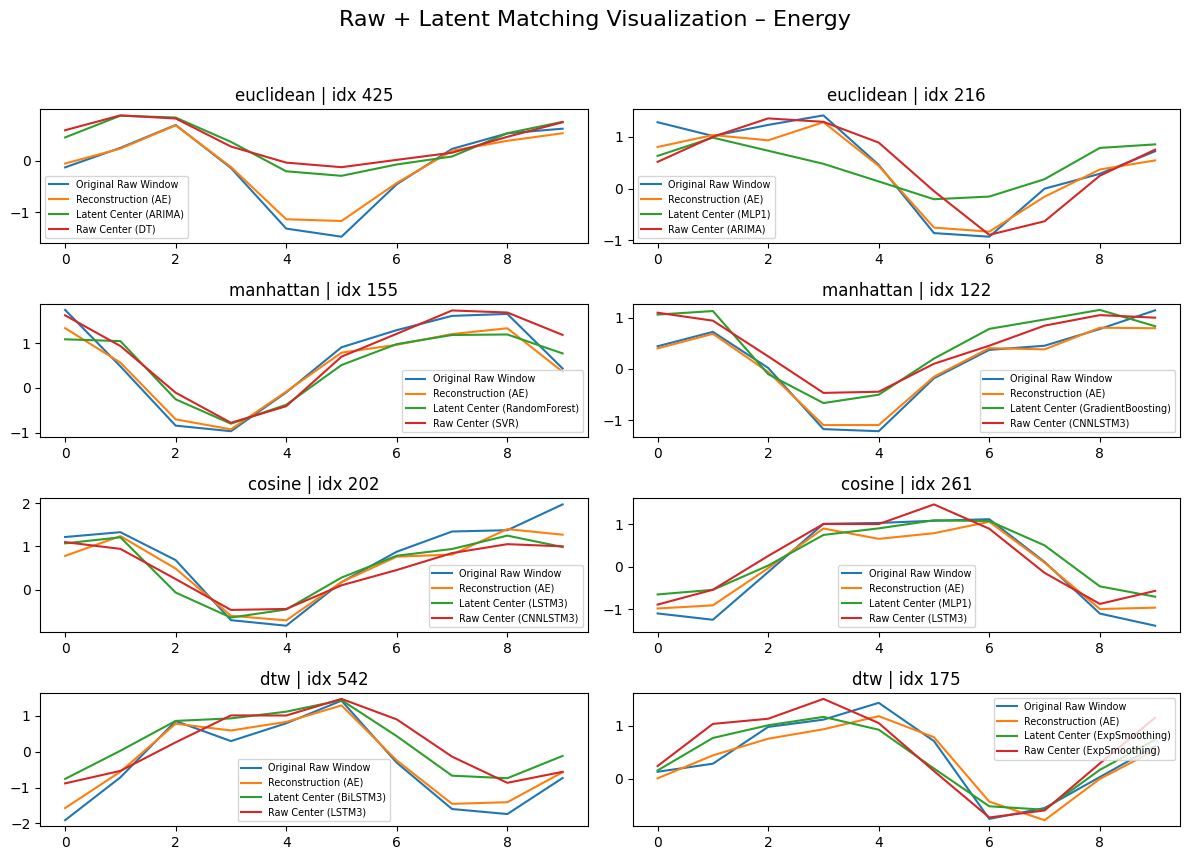

Processing dataset: RiverFlow


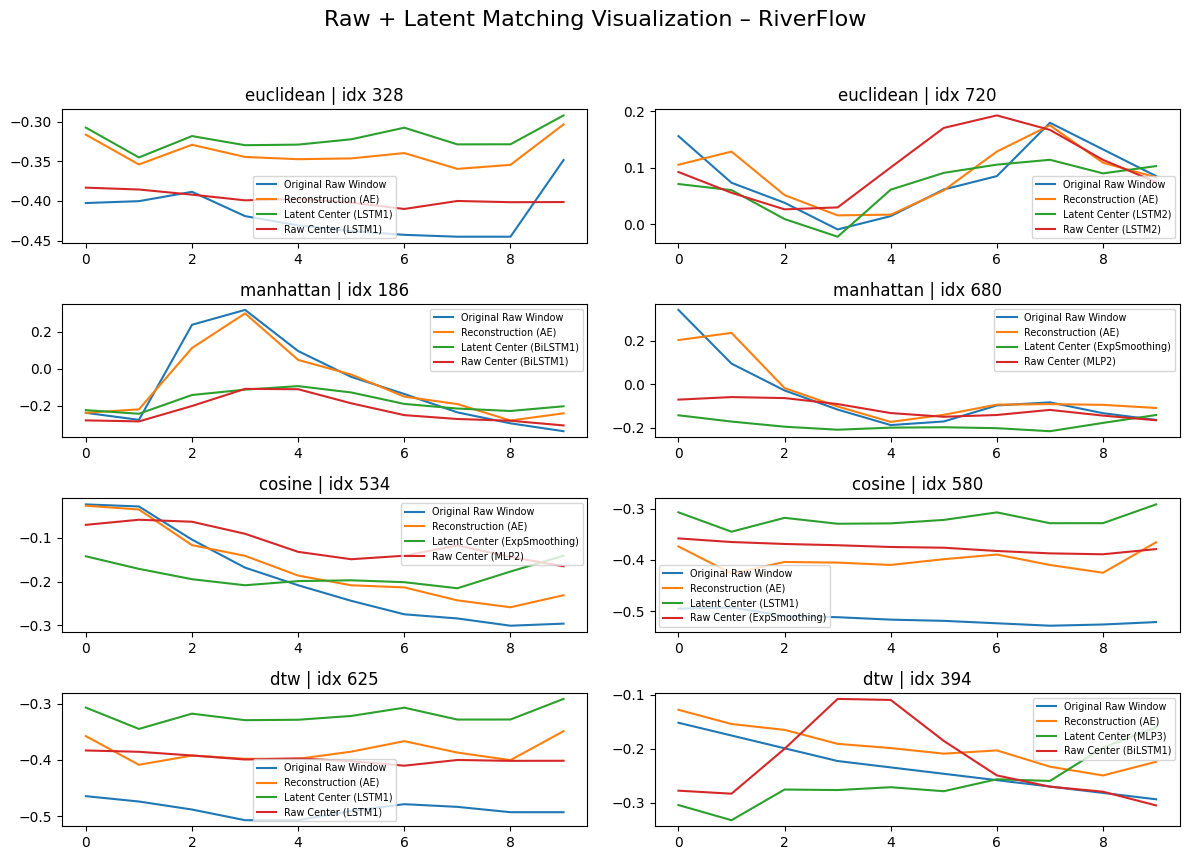

Processing dataset: Temperatures


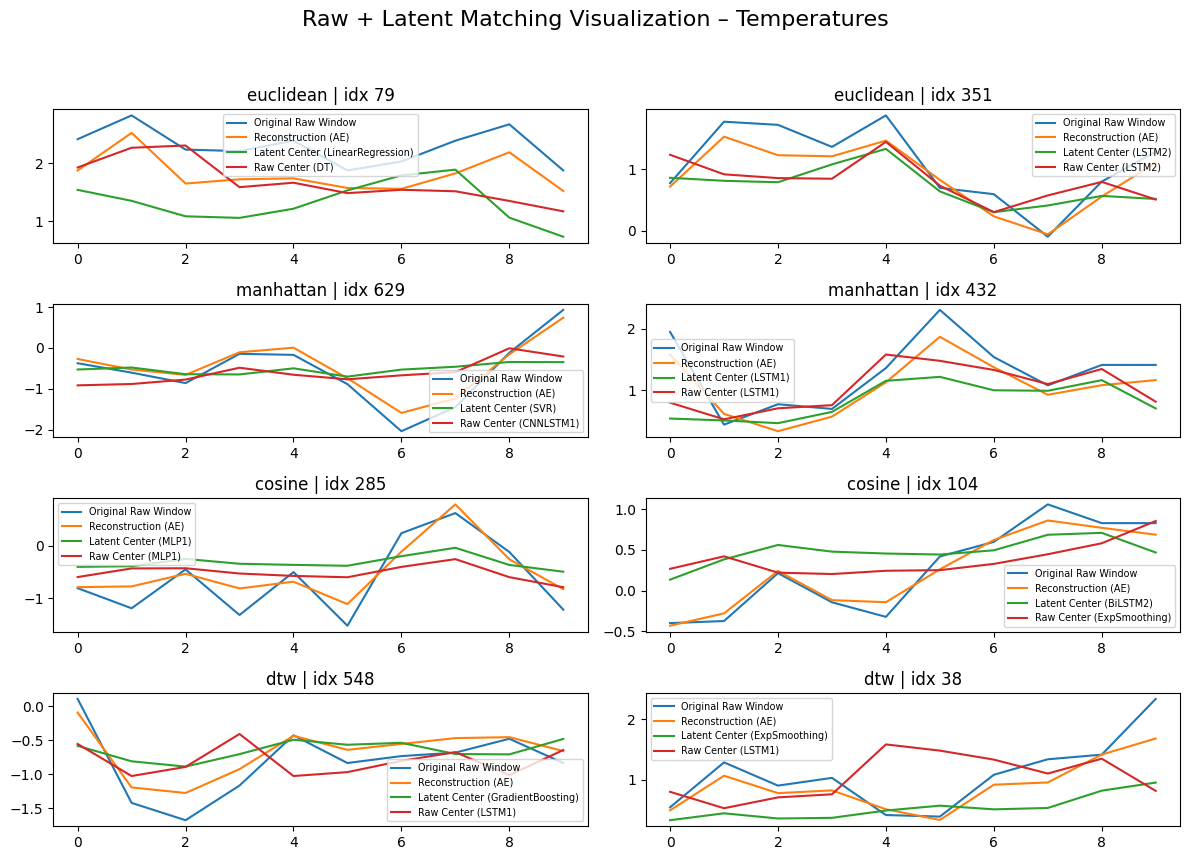

Processing dataset: Births


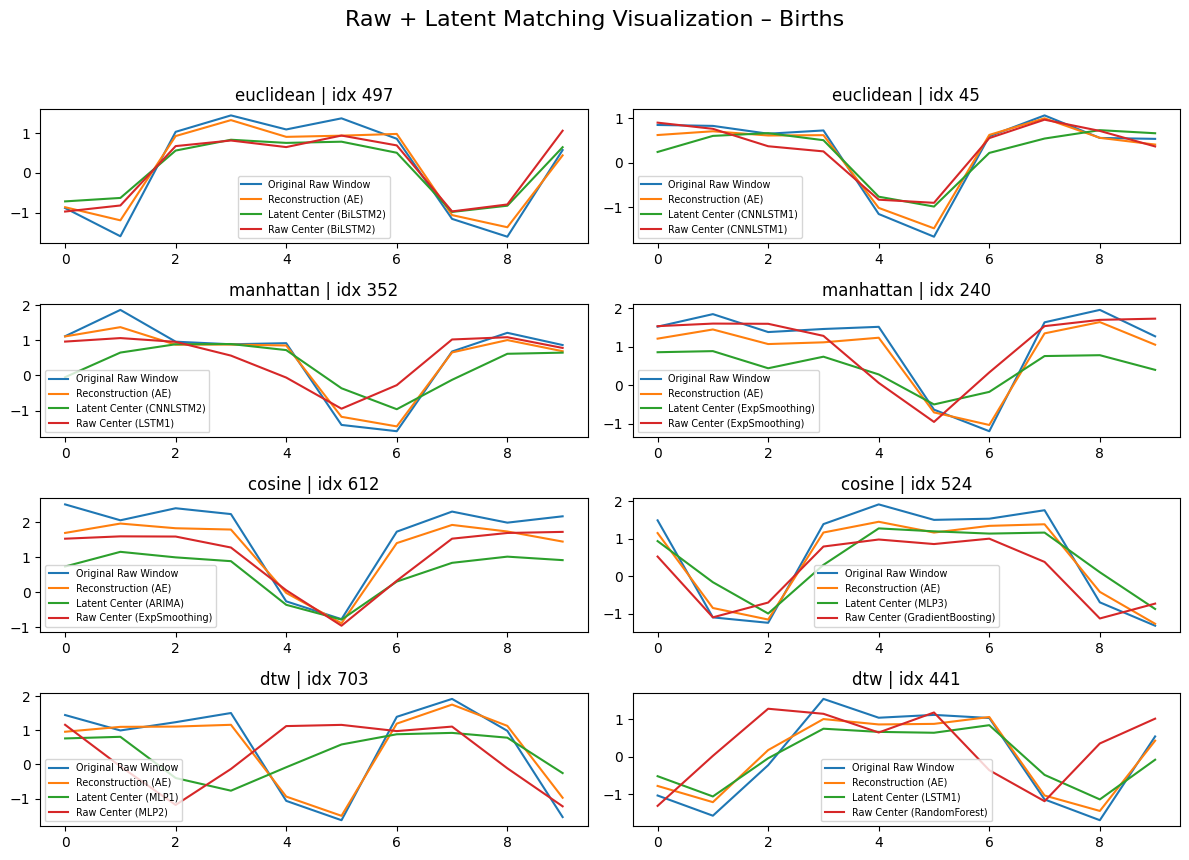

In [14]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"Processing dataset: {ds_name}")

    # Load dataset and create test windows
    ts = DS(length=length)
    _, _, _, _, X_test, _ = windowing(ts.data, window_size)

    # Load AE and forecasters
    ae = loaded[ds_name]['ae']
    forecasters = loaded[ds_name]['forecasters']
    decoder = ae.decoder
    decoder_device = next(decoder.parameters()).device

    # Prepare 3x2 subplot grid: 3 metrics × 2 windows per metric
    fig, axes = plt.subplots(len(metrics_list), 2, figsize=(12, 9))
    axes = axes.reshape(-1, 2)  # Ensure consistent indexing

    for i, metric in enumerate(metrics_list):
        idxs = random.sample(range(len(X_test)), 2)

        for j, idx in enumerate(idxs):
            ax = axes[i, j]
            w = X_test[idx]  # NumPy array

            # 1. Encode the window
            z = ae.encode(w)  # shape: (C, L)
            z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0).to(decoder_device)

            # 2. Reconstruct the window
            with torch.no_grad():
                w_recon = decoder(z_tensor).cpu().numpy().flatten()

            # 3. Find closest latent cluster center
            best_model_lat, best_dist_lat = None, float("inf")
            best_center_lat = None
            for name, model in forecasters.items():
                for center in model.centers["latent"]:
                    c_tensor = center if isinstance(center, torch.Tensor) else torch.tensor(center, dtype=torch.float32)
                    c_tensor = c_tensor.to(decoder_device)
                    d = compute_distance(z_tensor.squeeze(0), c_tensor, metric=metric)
                    if d < best_dist_lat:
                        best_dist_lat = d
                        best_model_lat = name
                        best_center_lat = c_tensor

            # 4. Decode latent center
            with torch.no_grad():
                proto_latent = decoder(best_center_lat.unsqueeze(0)).cpu().numpy().flatten()

            # 5. Find closest raw cluster center
            best_model_raw, best_dist_raw = None, float("inf")
            best_center_raw = None
            for name, model in forecasters.items():
                for center in model.centers["raw"]:
                    center_np = center if isinstance(center, np.ndarray) else center.cpu().numpy()
                    d = compute_distance(w, center_np, metric=metric)
                    if d < best_dist_raw:
                        best_dist_raw = d
                        best_model_raw = name
                        best_center_raw = center_np

            # 6. Plot all
            ax.plot(w, label="Original Raw Window")
            ax.plot(w_recon, label="Reconstruction (AE)")
            ax.plot(proto_latent, label=f"Latent Center ({best_model_lat})")
            ax.plot(best_center_raw, label=f"Raw Center ({best_model_raw})")
            ax.set_title(f"{metric} | idx {idx}")
            ax.legend(fontsize="x-small")

    # Final layout
    fig.suptitle(f"Raw + Latent Matching Visualization – {ds_name}", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
